In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
from datetime import date, timedelta
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.23.4
numpy==1.16.4
matplotlib==2.2.3


In [3]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                pass
#                 print(
#                     'iter %d. reward: %f'
#                     % (i + 1, self.reward_function(self.weights))
#                 )
#         print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [4]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money, close):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.close = close
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= self.close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
#                 print('day %d: buy 1 unit at price %f, total inventory %f, total balance %f'% (t, self.trend[t], len(inventory), initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
#                 print(
#                     'day %d, sell 1 unit at price %f,  total inventory %f, investment %f %%, total balance %f,'
#                     % (t, close[t], len(inventory), invest, initial_money)
#                 )
            state = next_state
            

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [5]:
def get_df(ticker, years):
    df = pd.read_csv('./data/{}.csv'.format(ticker), header=0)
    start_date = date.today() - timedelta(days=years * 365)
    df = df[df.Date >= str(start_date)]
    return df

import csv

def write_statistics(lst, file_name):
    #accepts list of lists
    #csvData = [['Column1', 'Colum2'], ['Peter', '22'], ['Jasmine', '21'], ['Sam', '24']]

    with open('{}.csv'.format(file_name), 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(lst)
    csvFile.close()

1


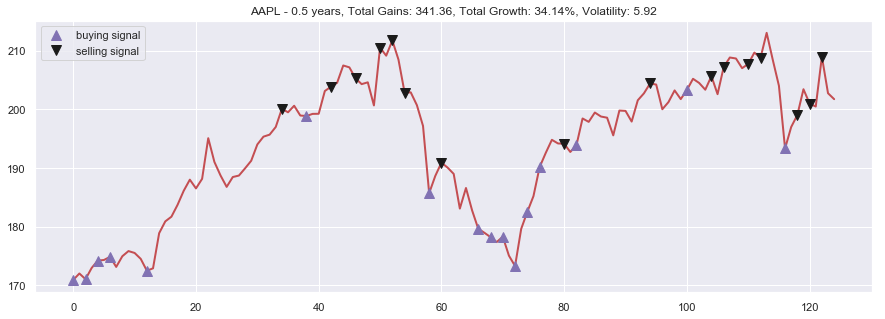

1


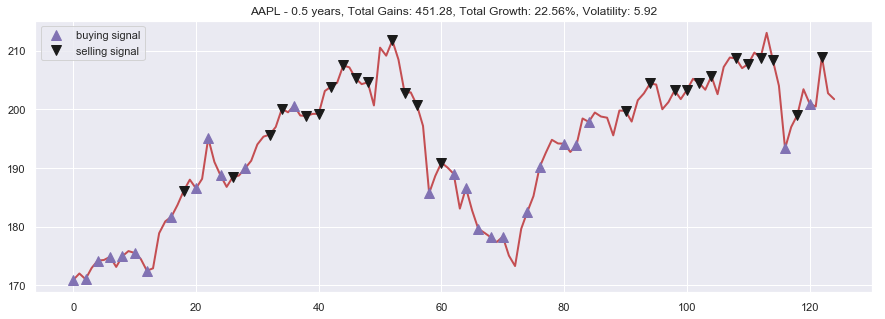

1


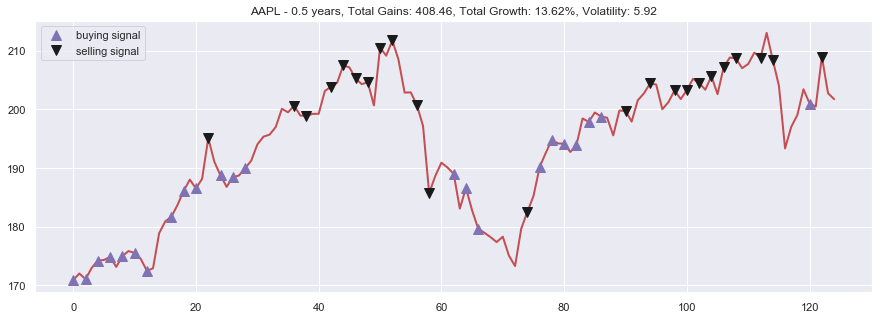

1


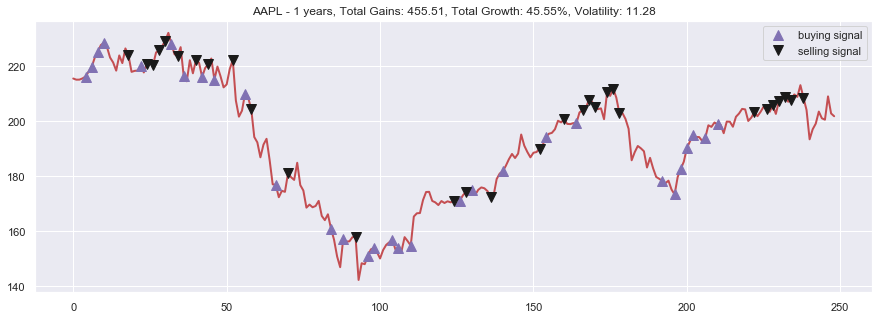

1


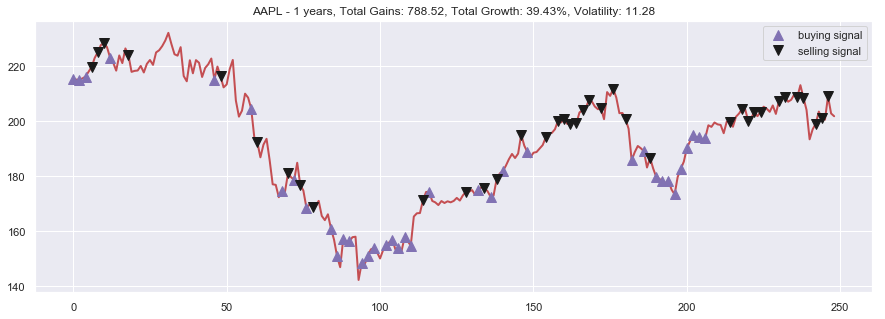

1


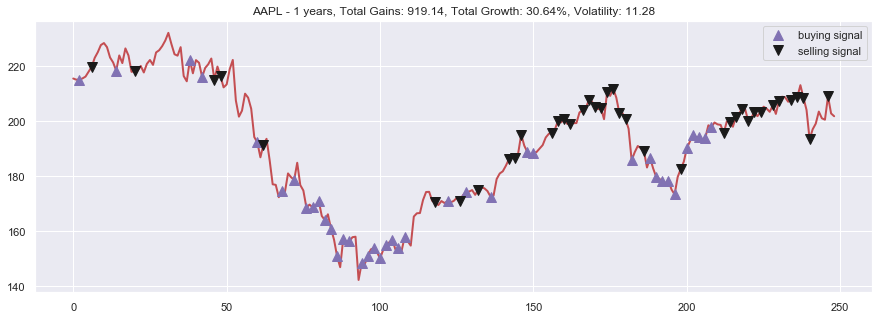

1


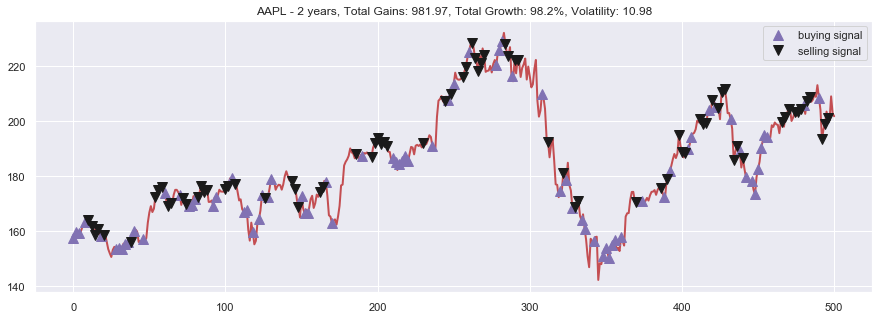

1


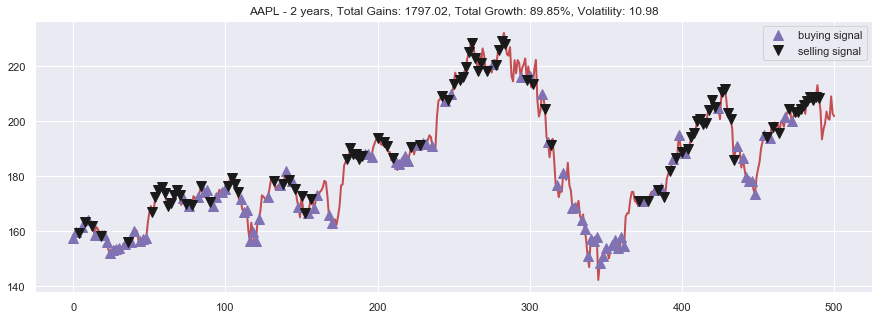

1


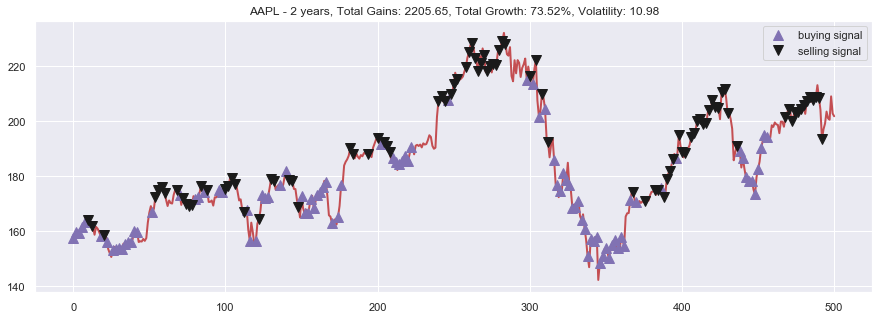

1


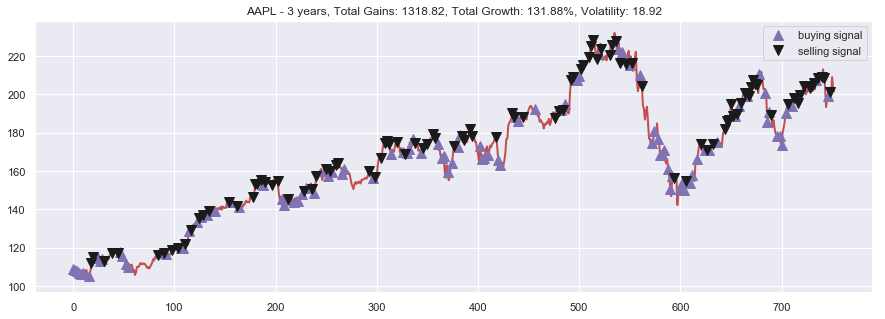

1


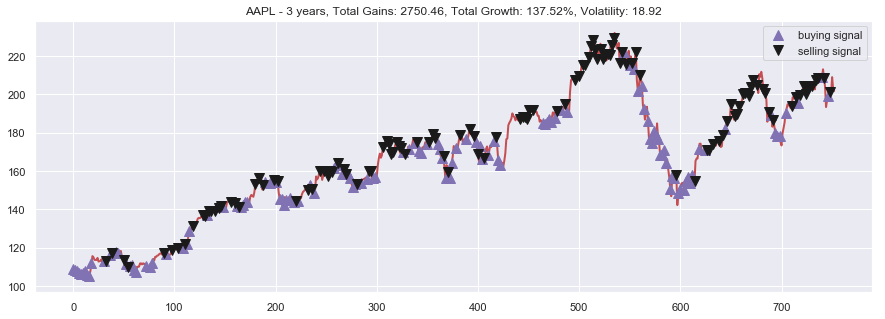

1


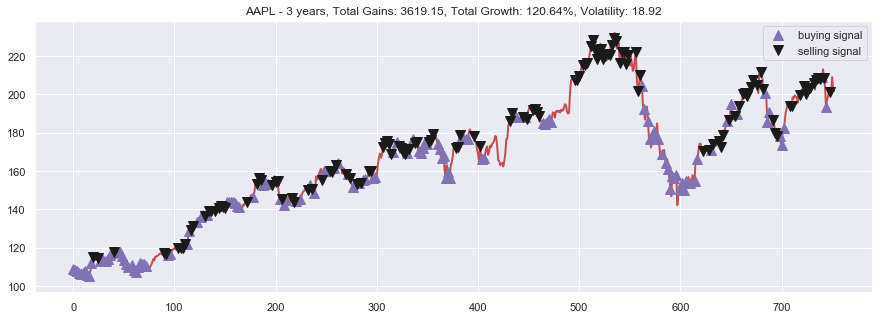

1


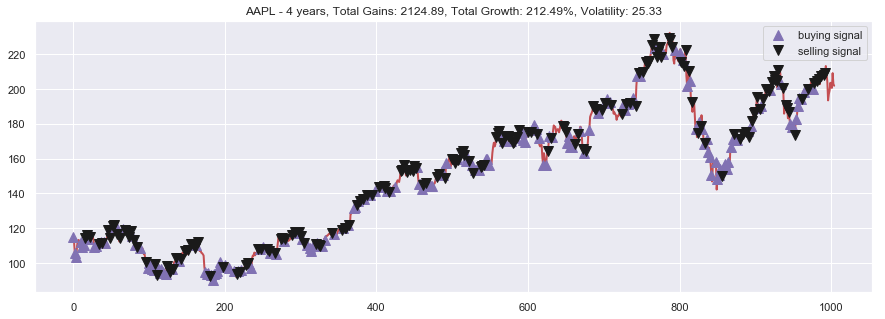

1


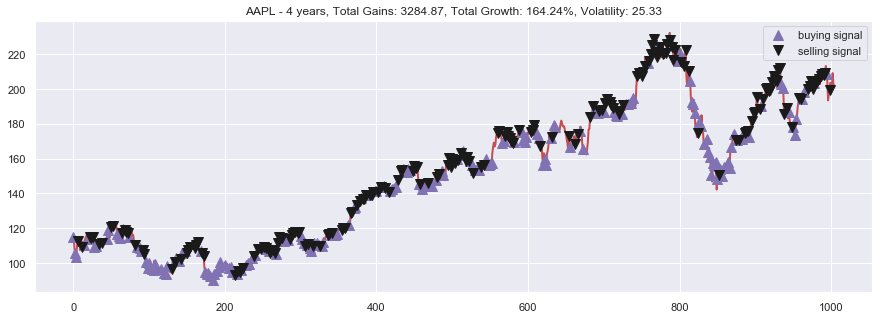

1


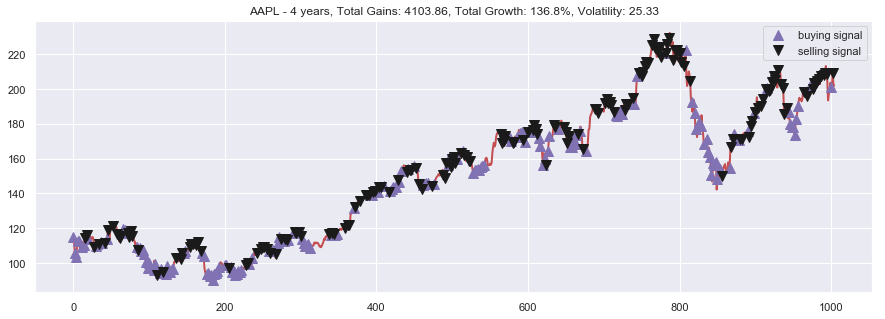

1


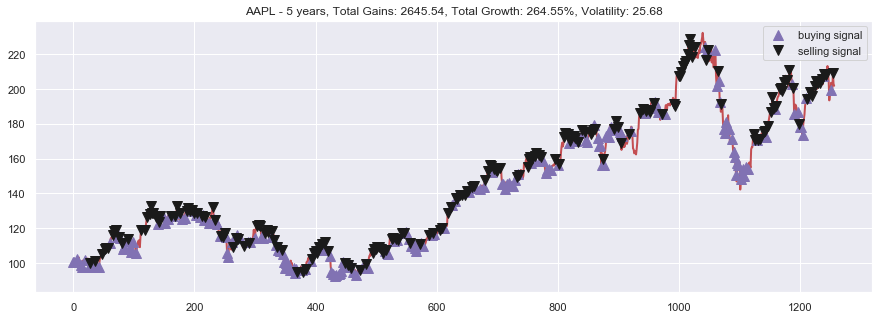

1


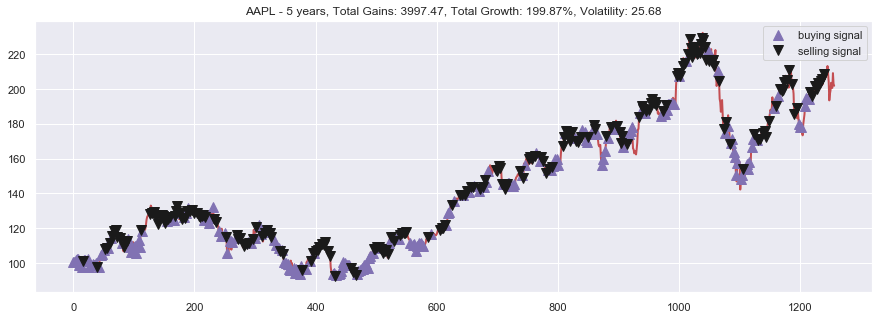

1


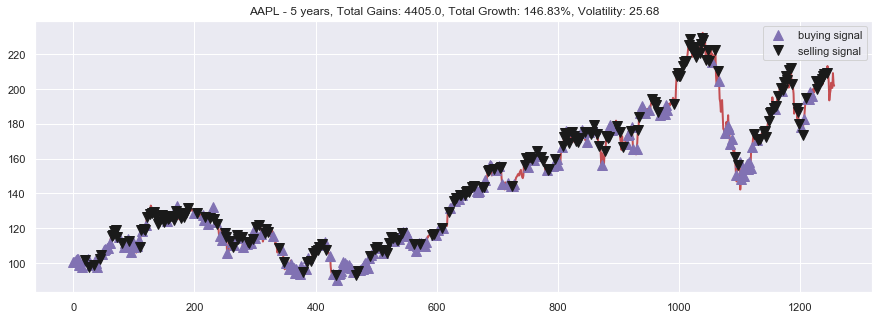

1


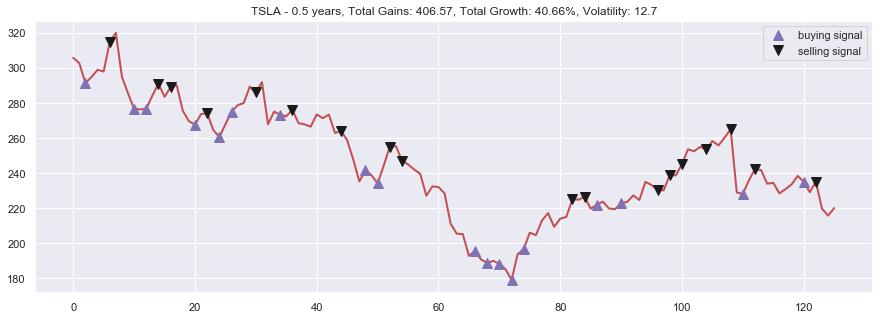

1


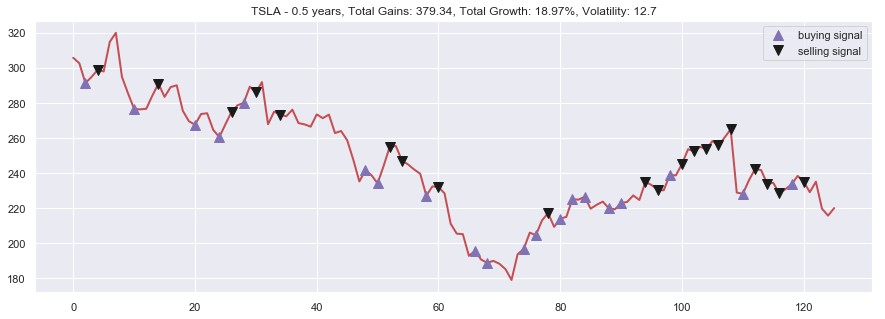

1


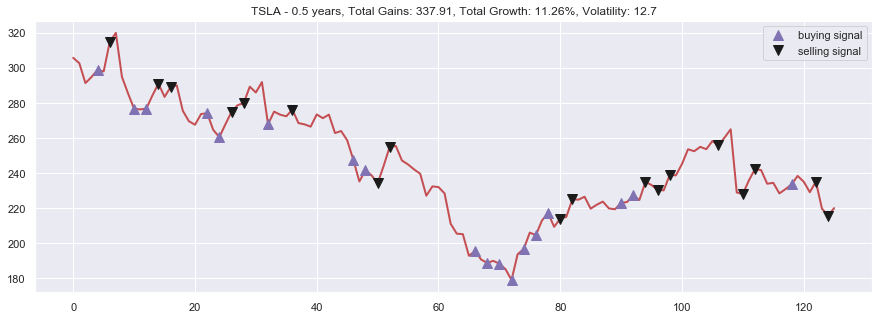

1


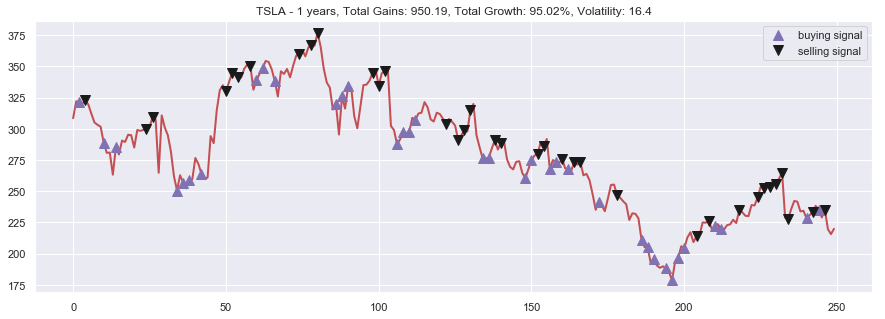

1


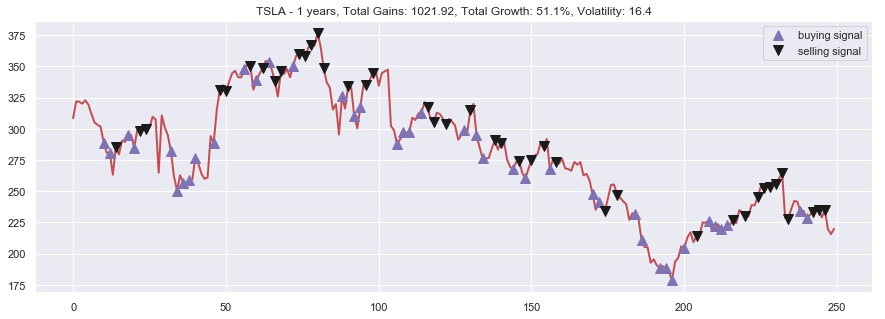

1


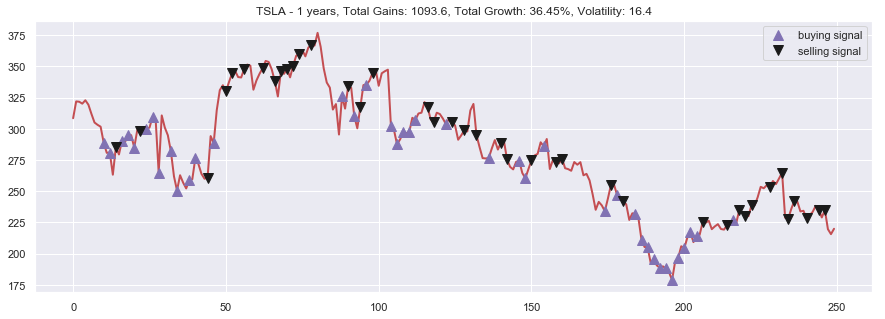

1


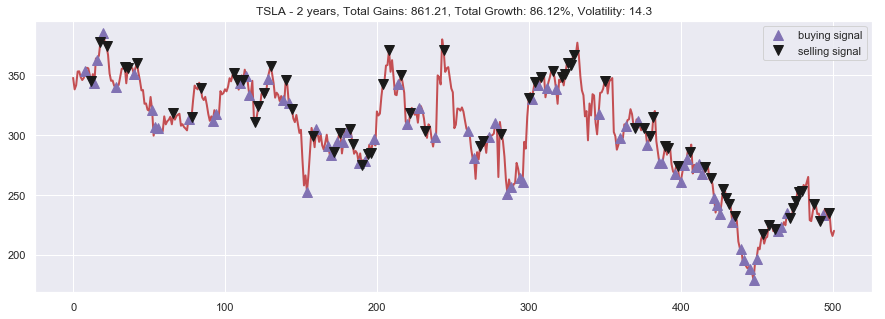

1


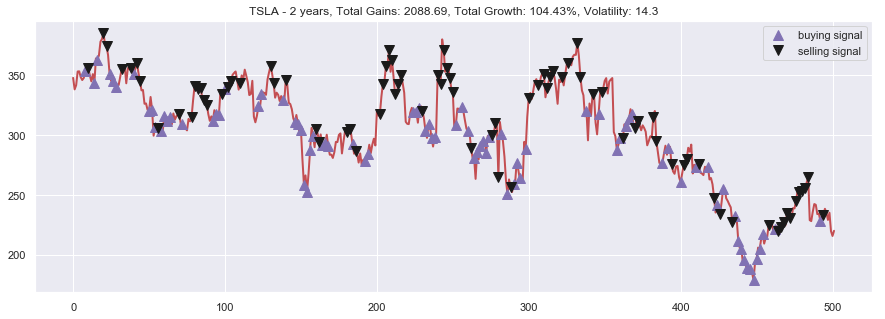

1


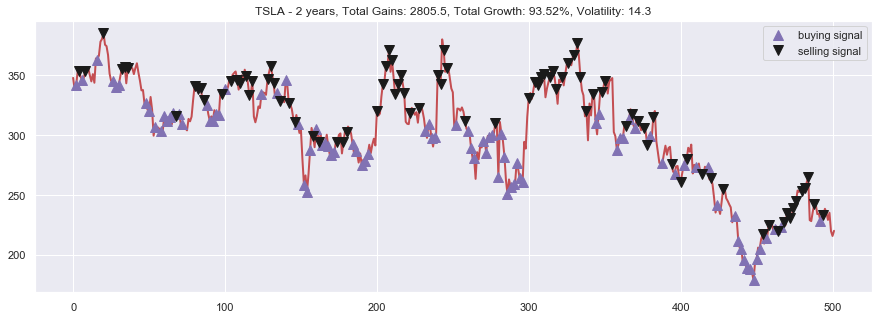

1


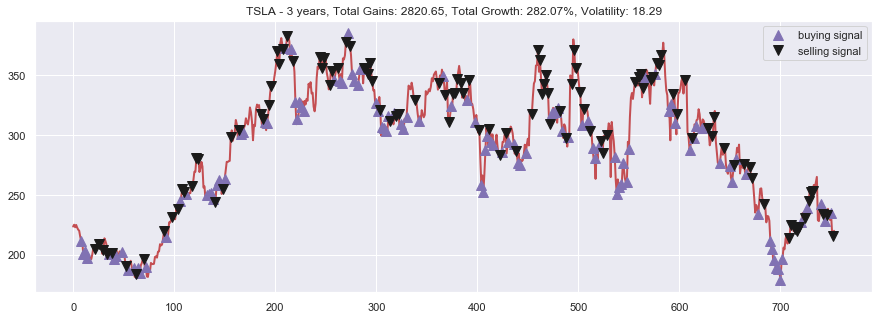

1


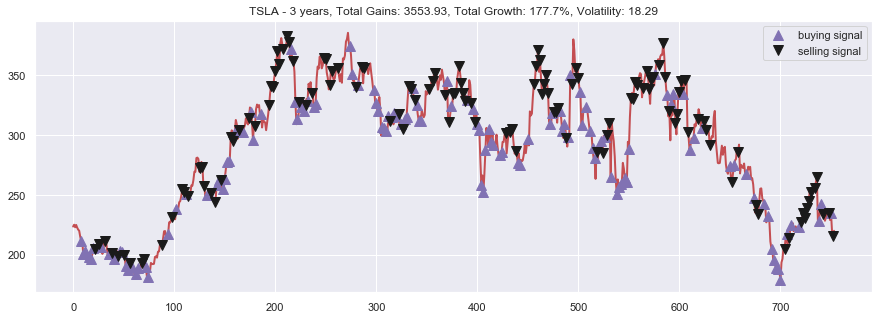

1


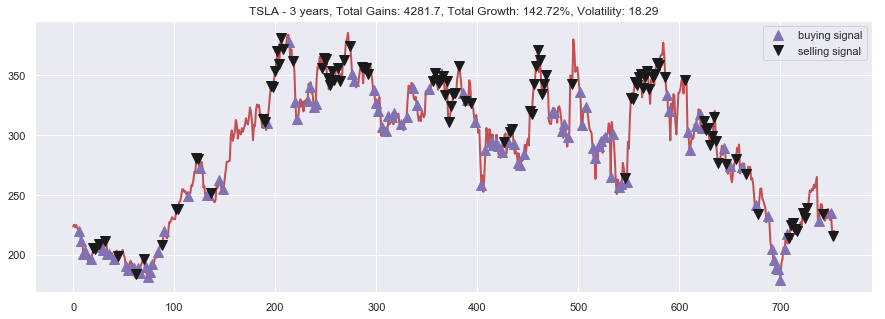

1


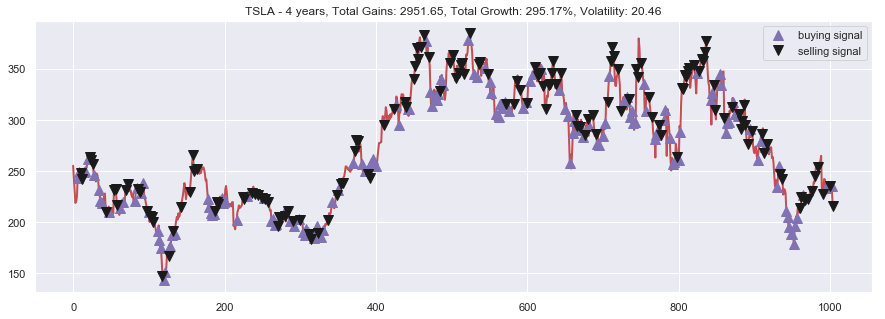

1


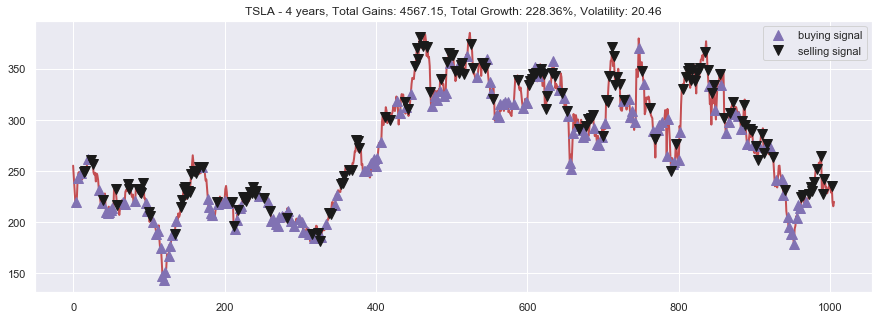

1


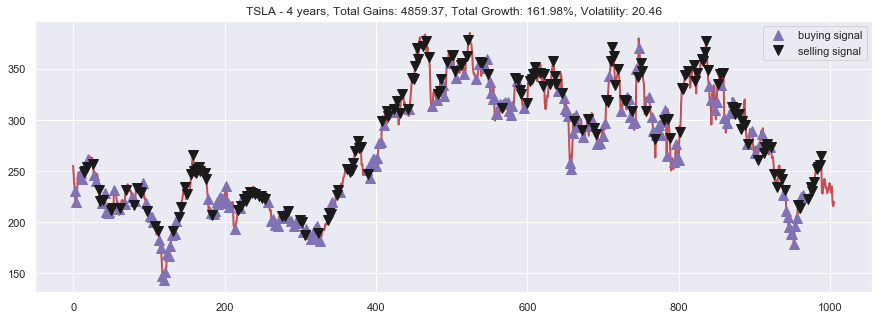

1


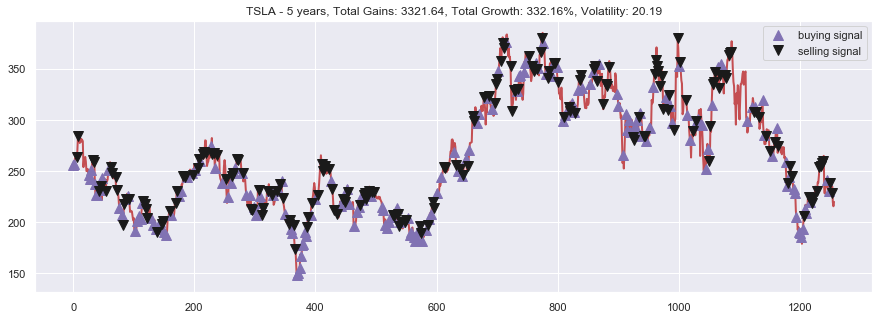

1


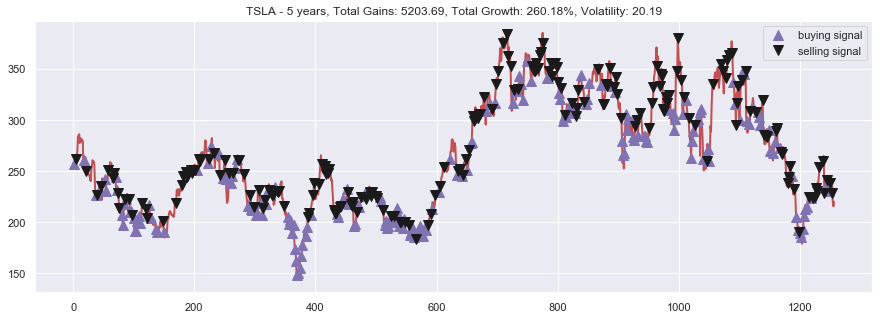

1


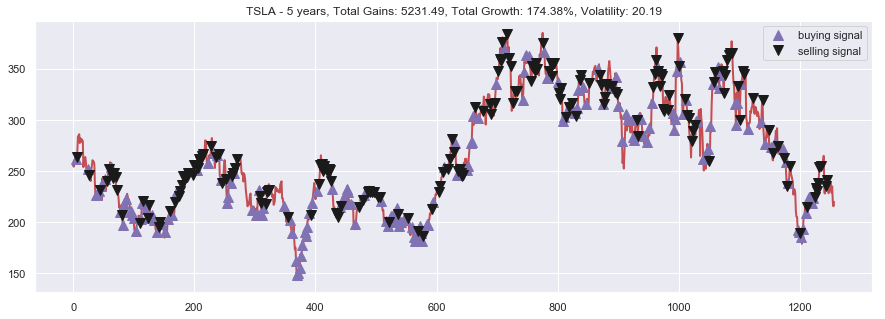

1


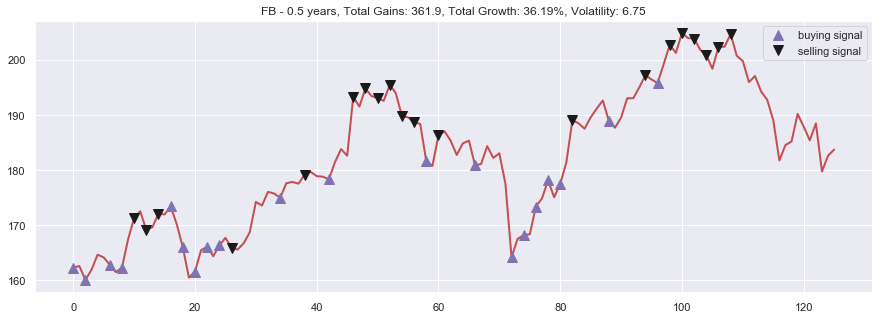

1


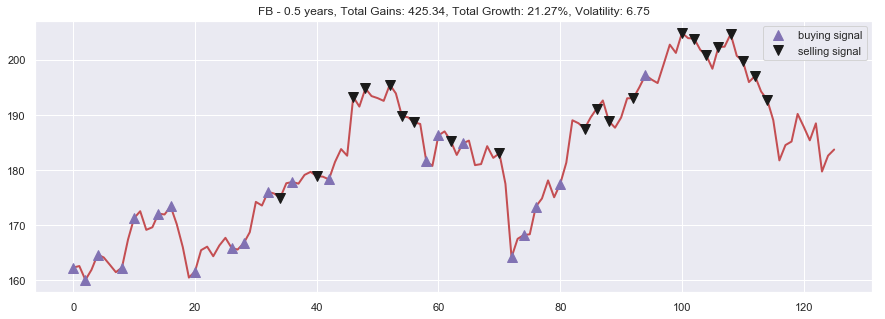

1


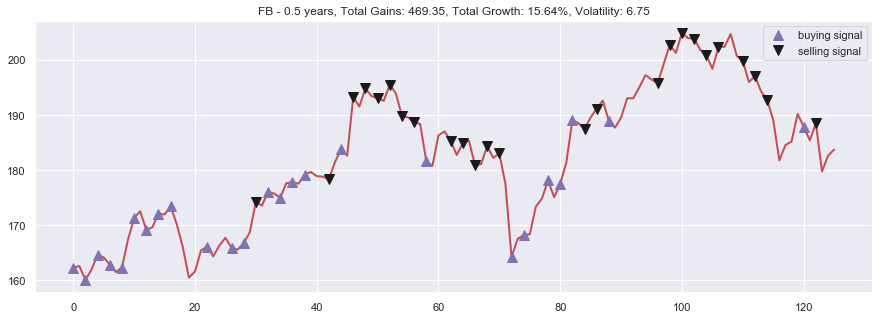

1


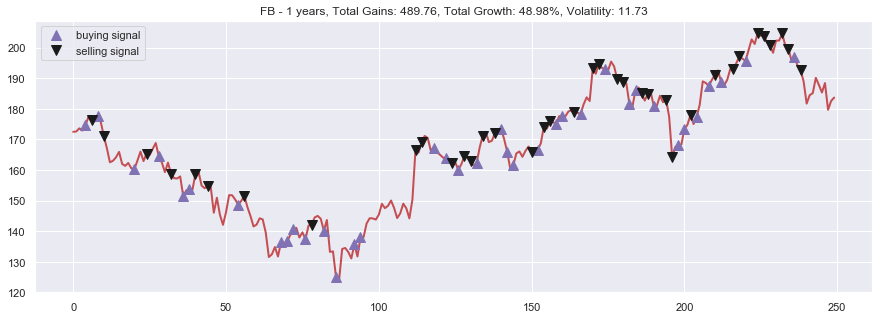

1


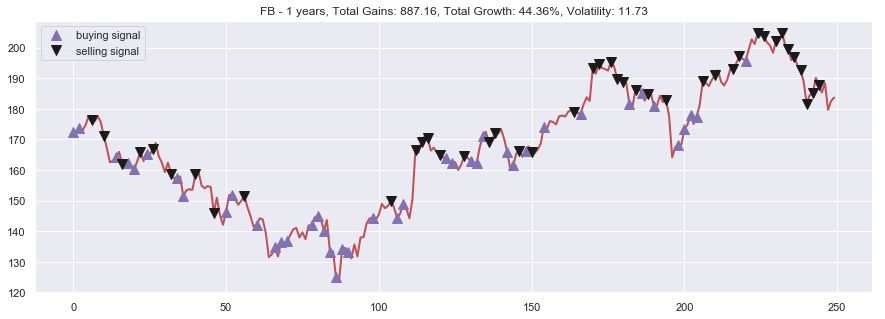

1


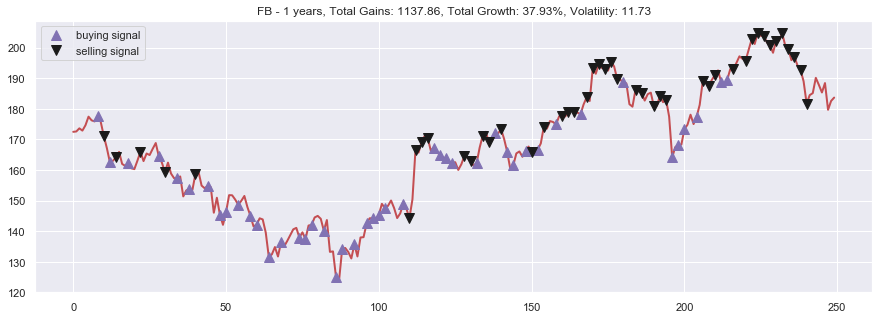

1


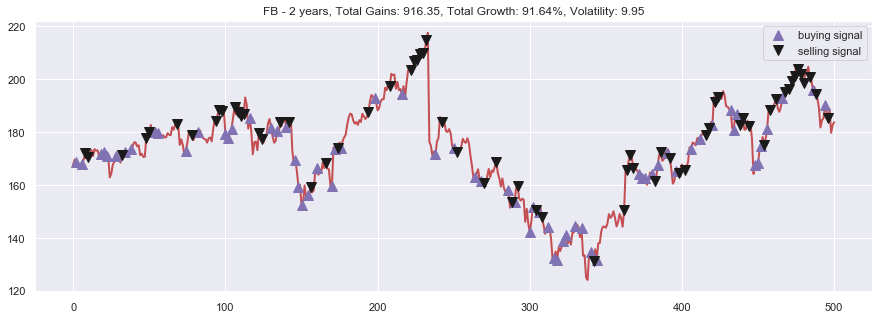

1


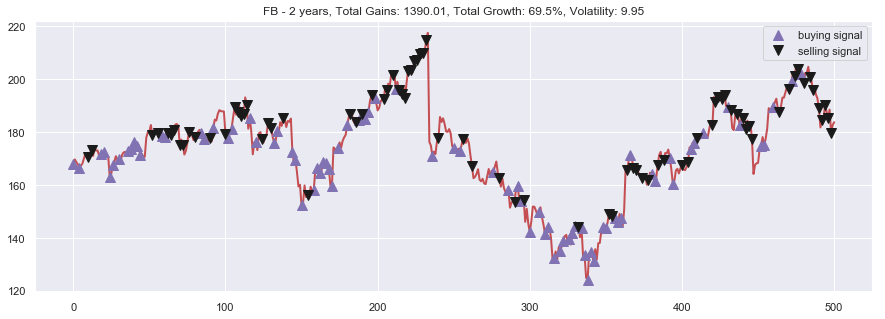

1


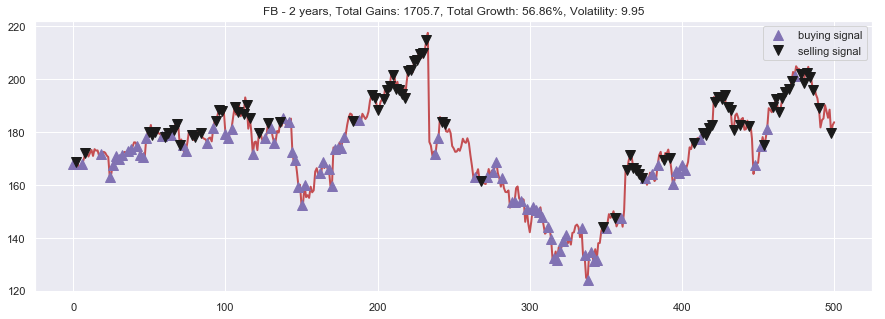

1


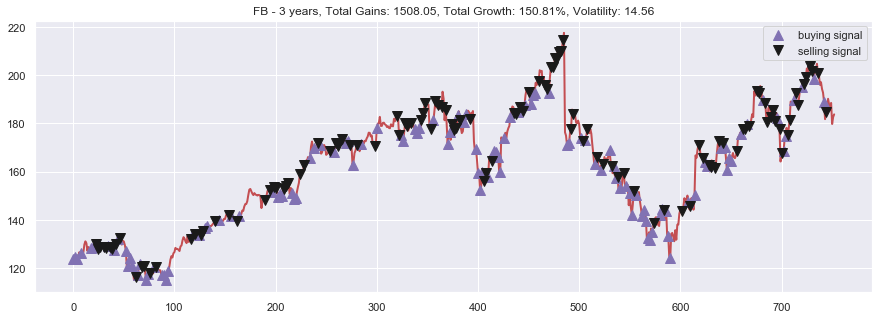

1


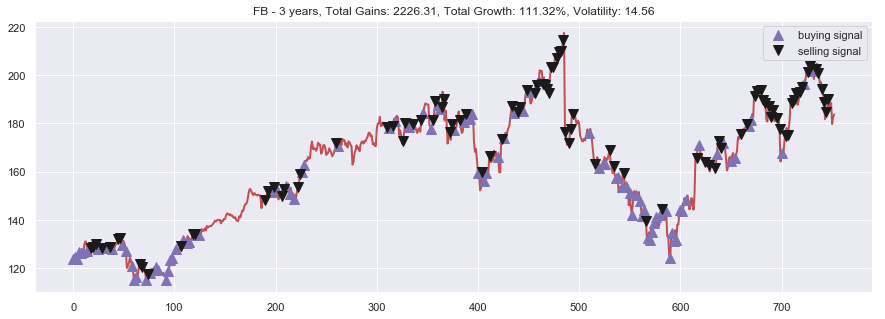

1


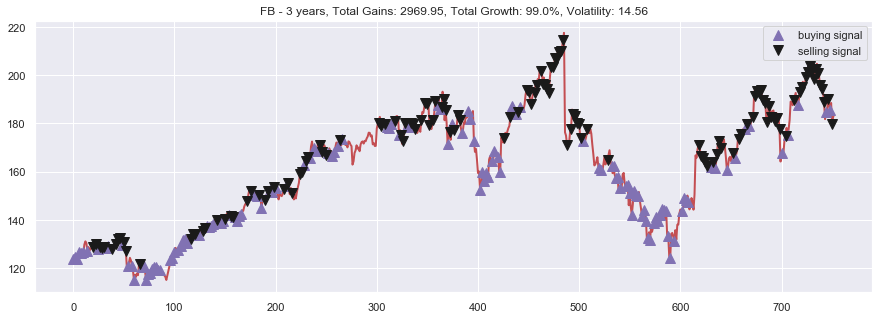

1


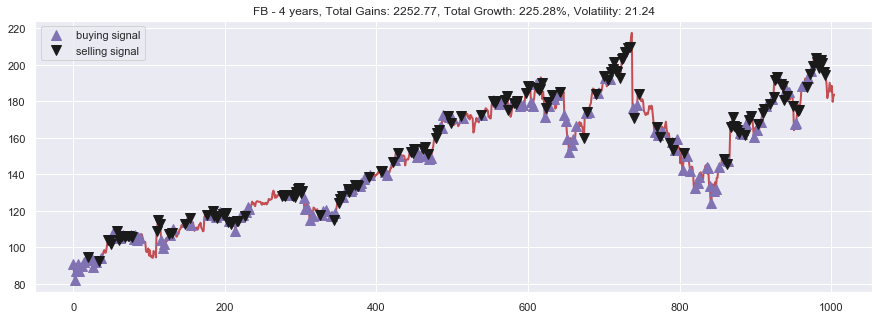

1


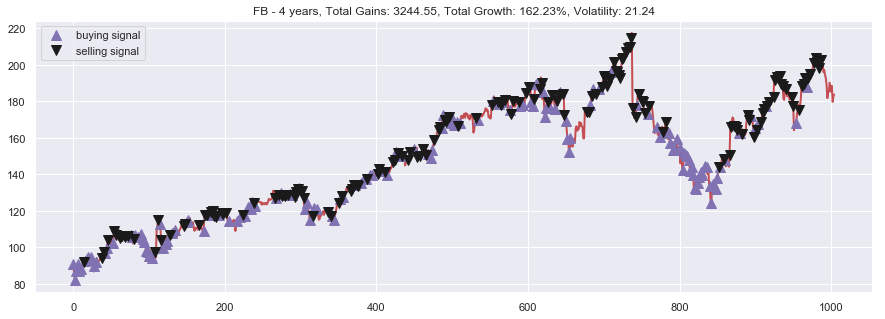

1


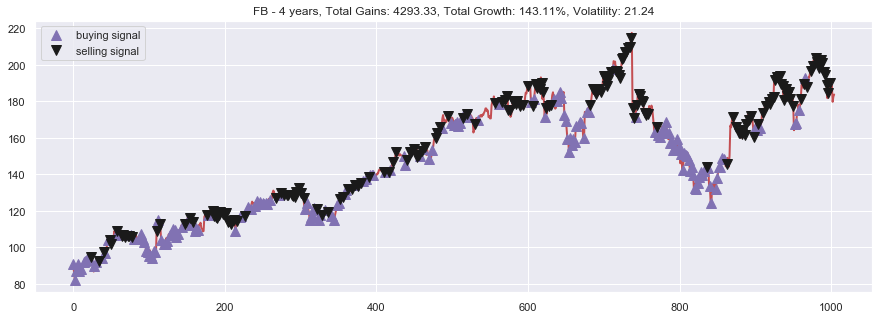

1


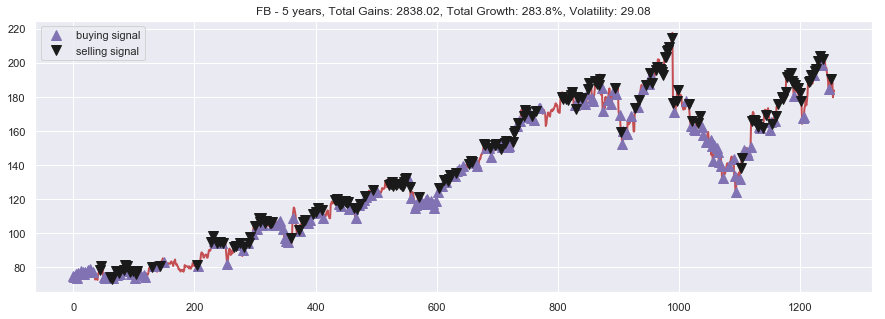

1


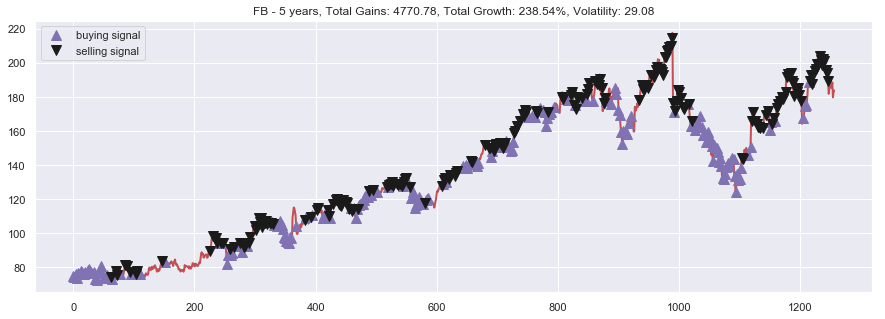

1


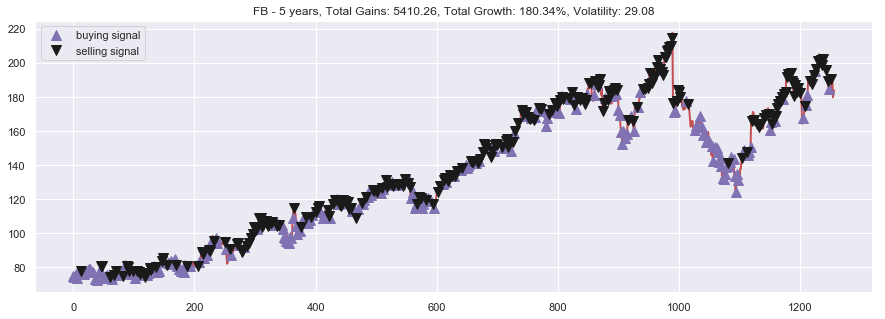

1


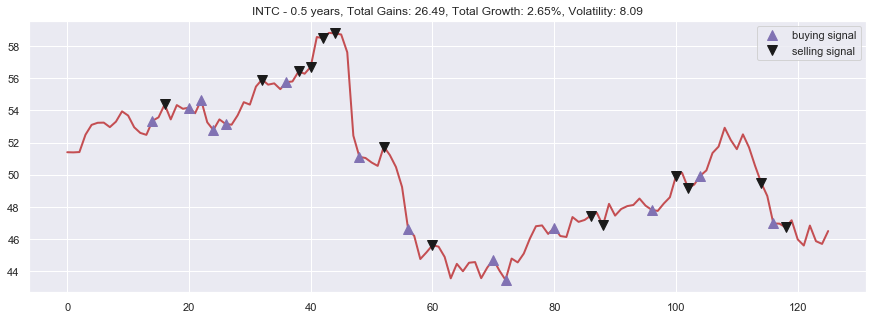

1


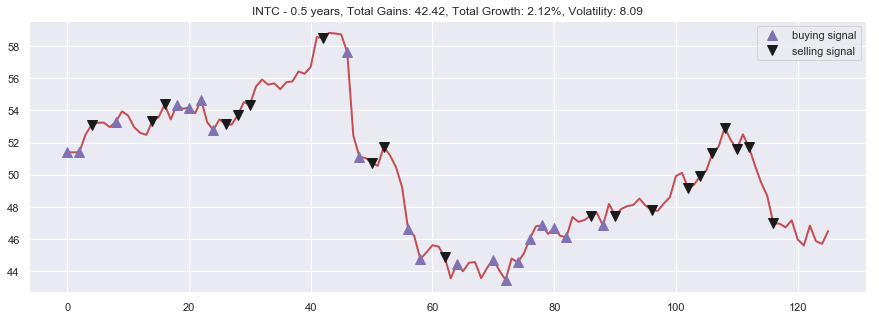

1


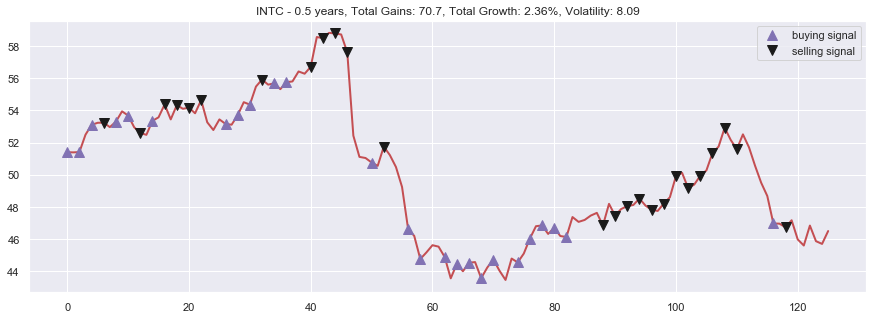

1


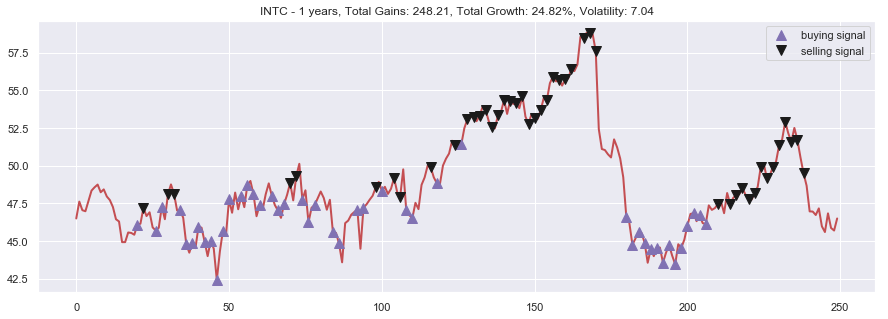

1


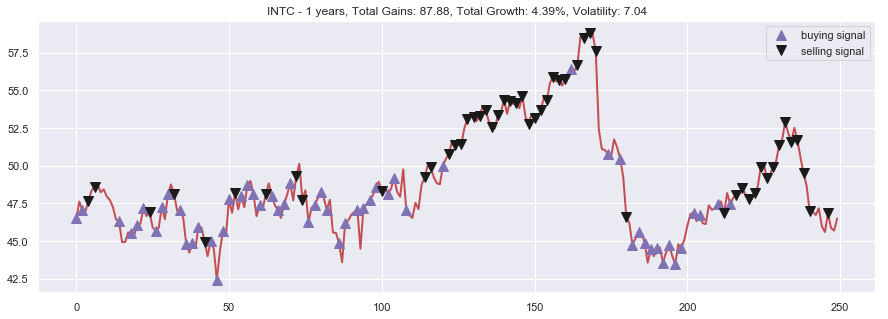

1


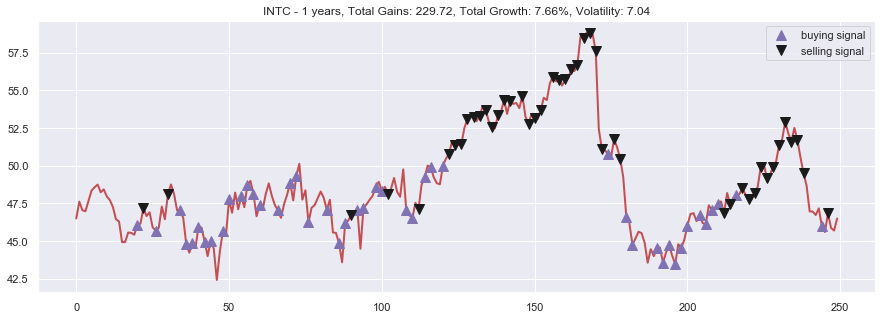

1


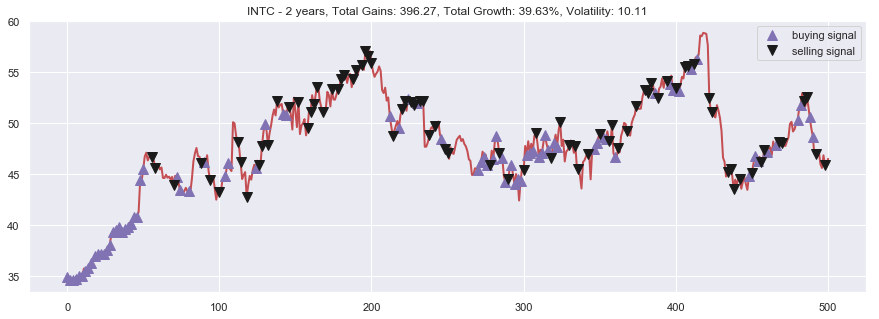

1


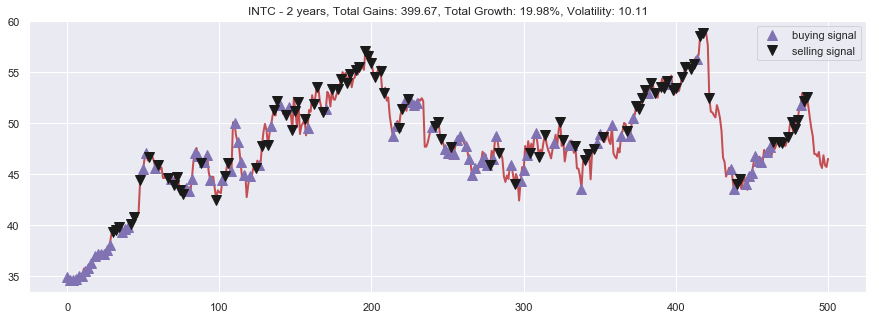

1


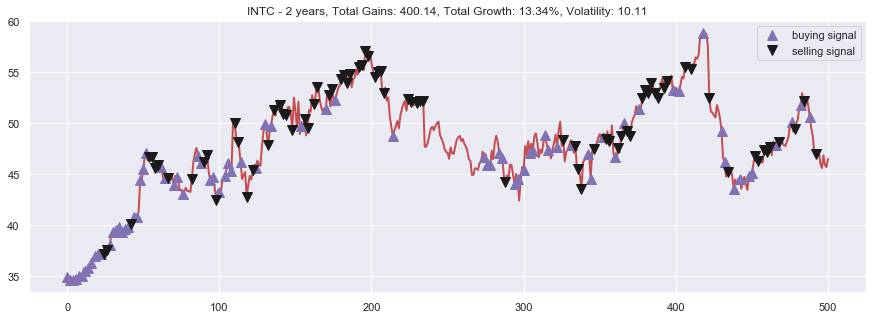

1


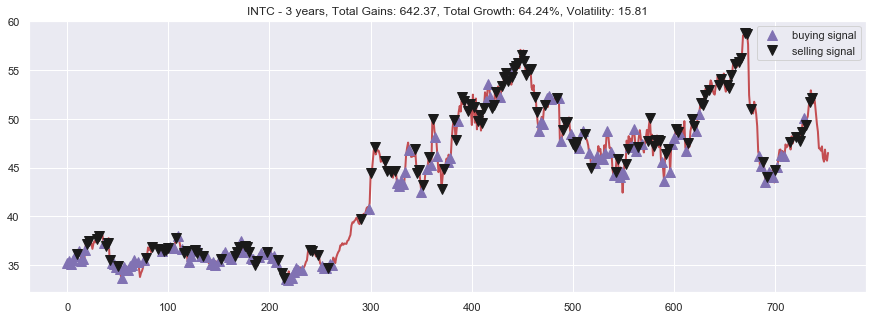

1


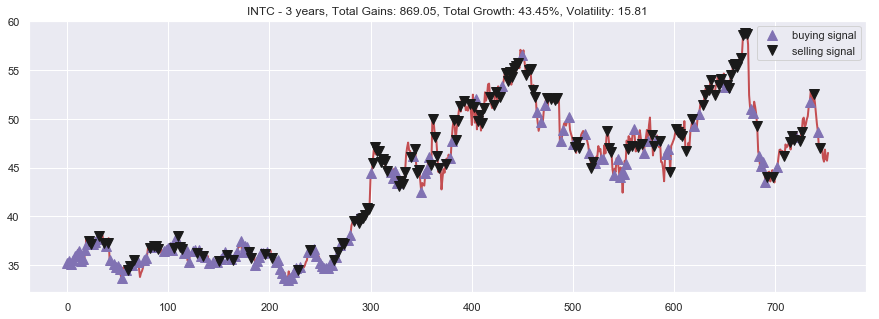

1


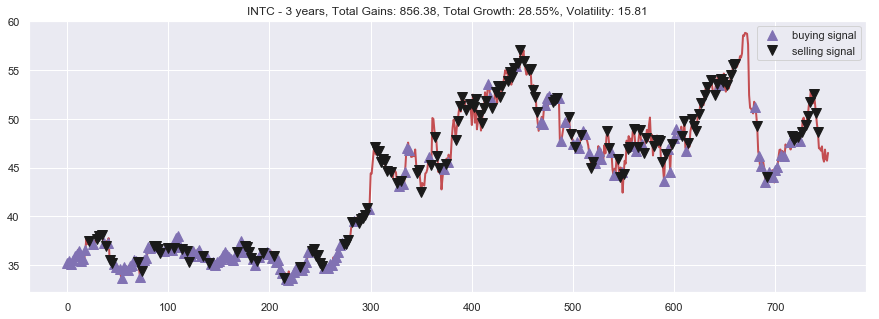

1


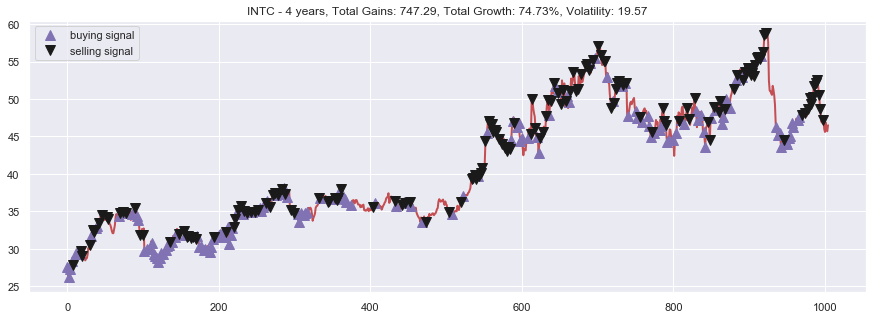

1


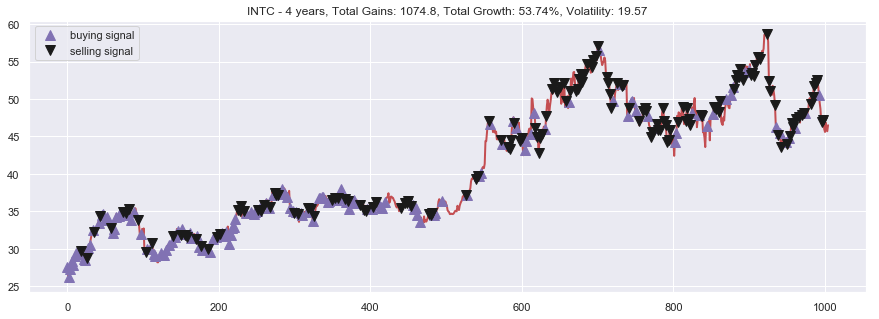

1


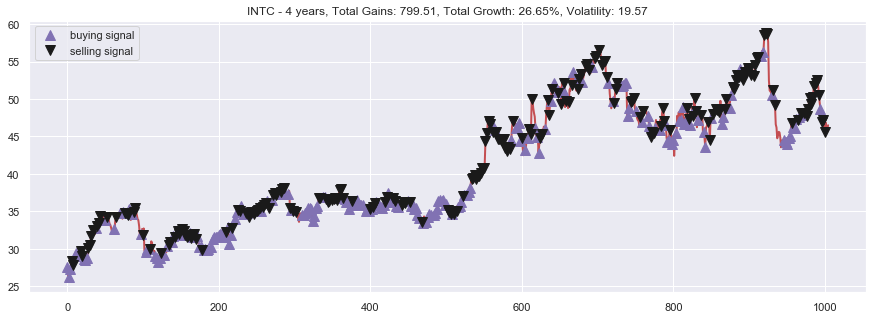

1


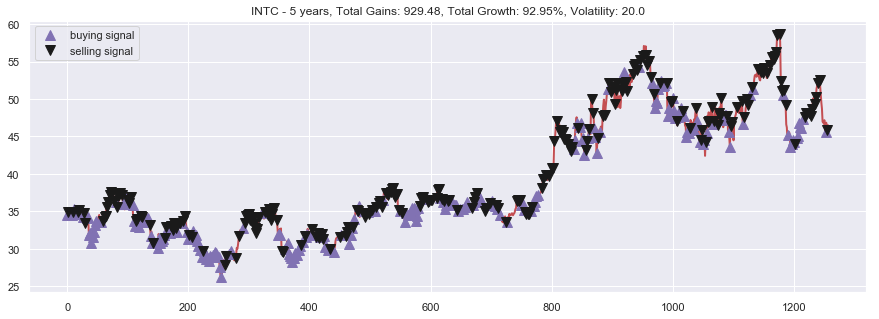

1


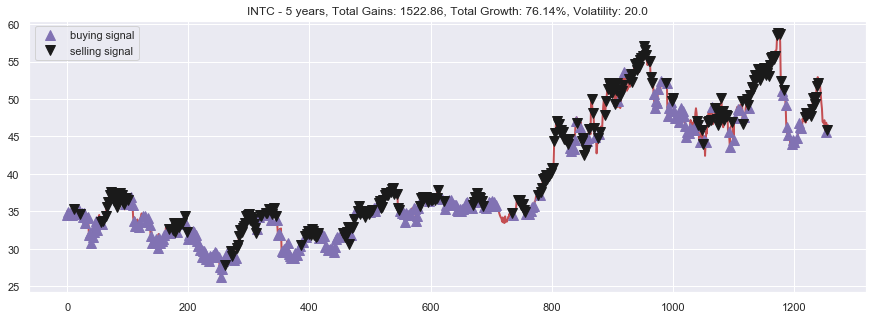

1


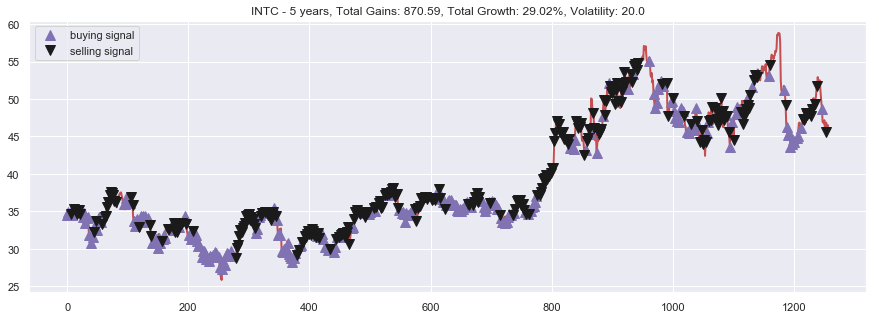

1


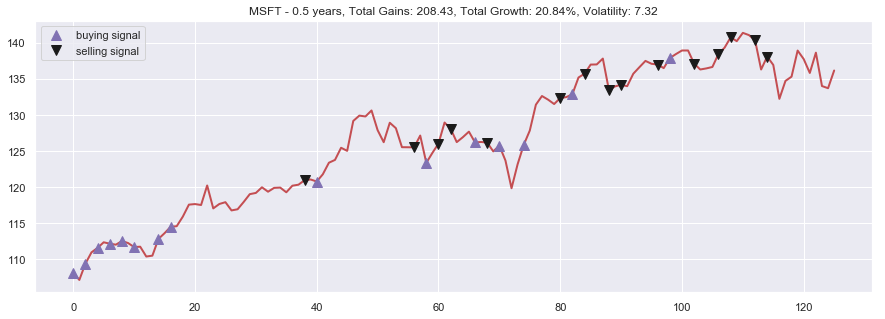

1


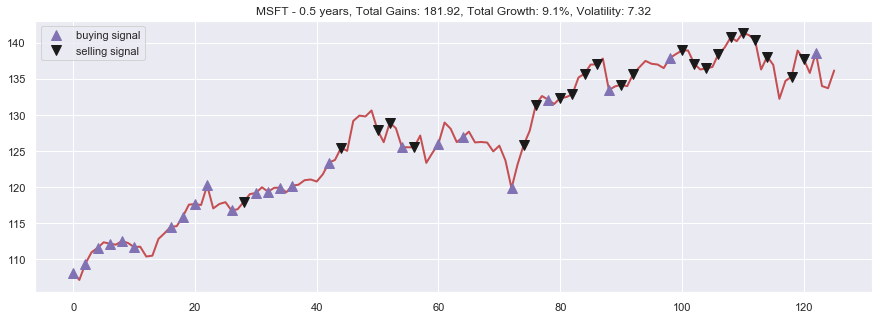

1


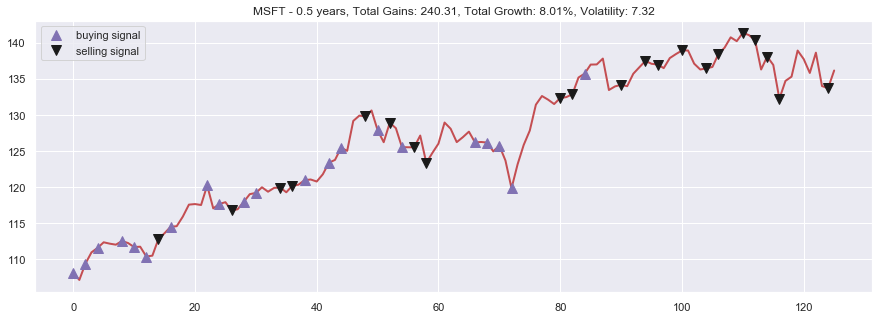

1


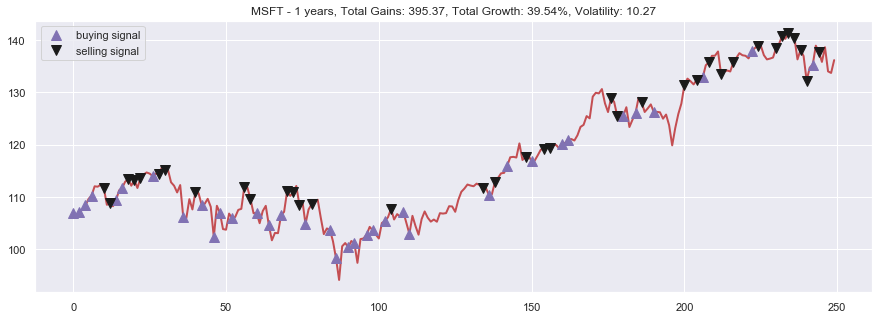

1


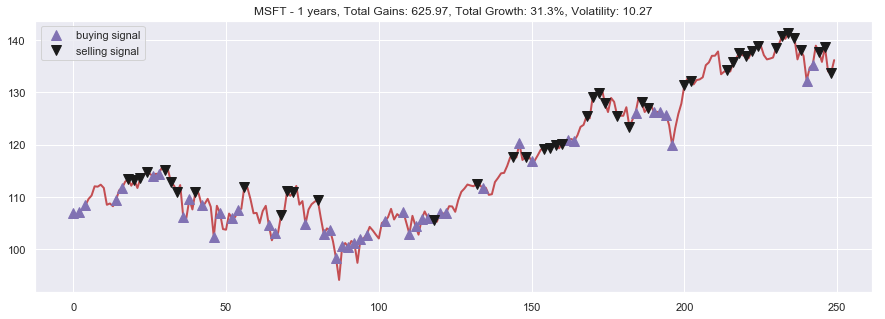

1


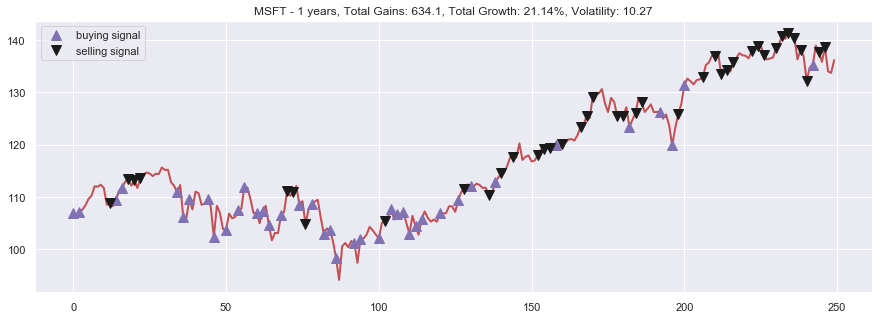

1


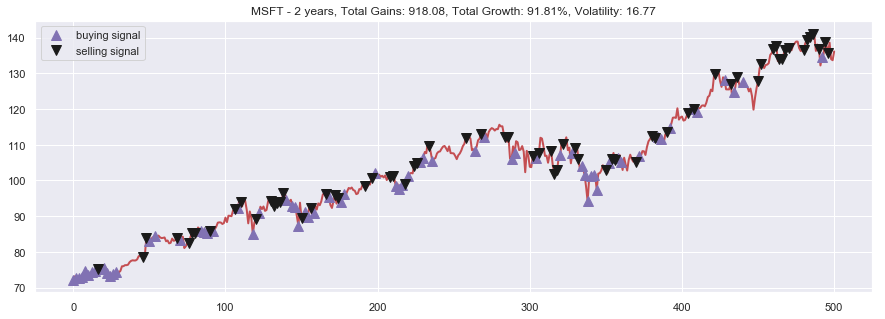

1


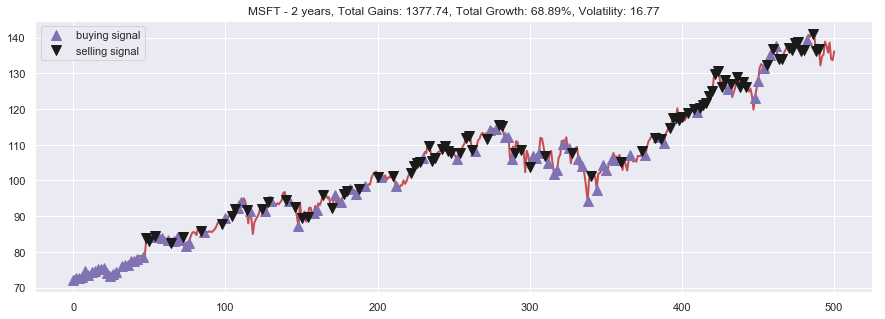

1


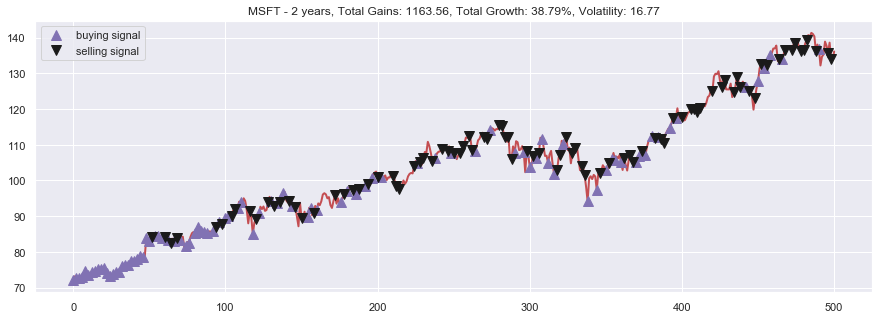

1


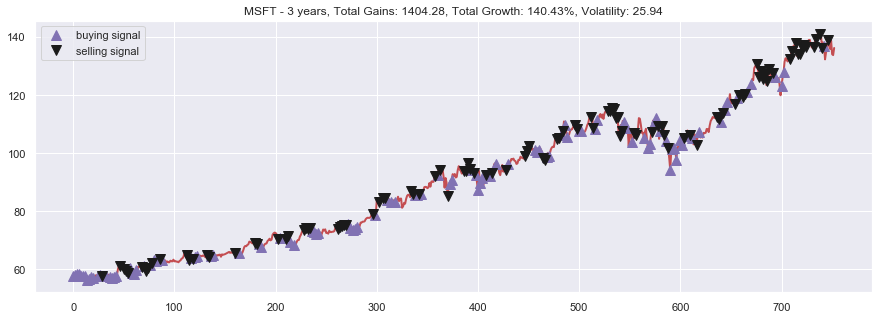

1


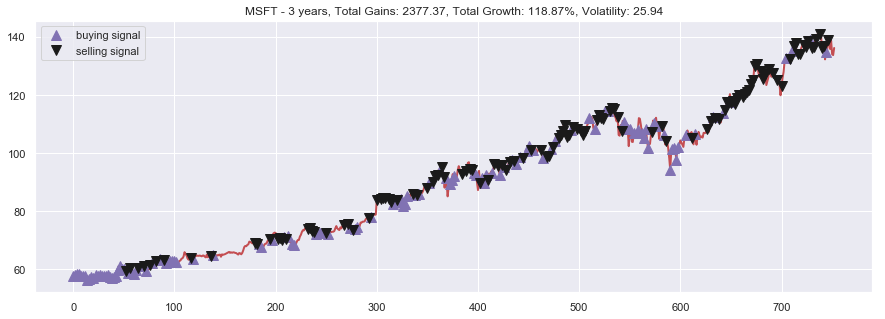

1


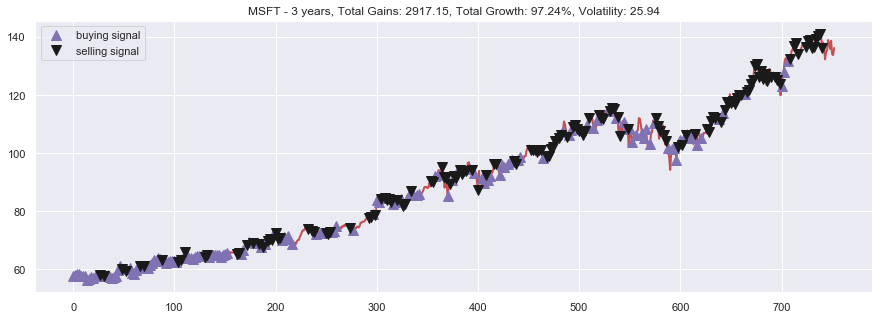

1


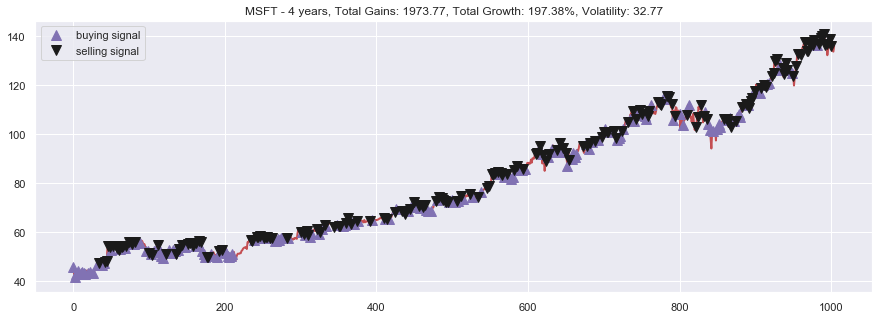

1


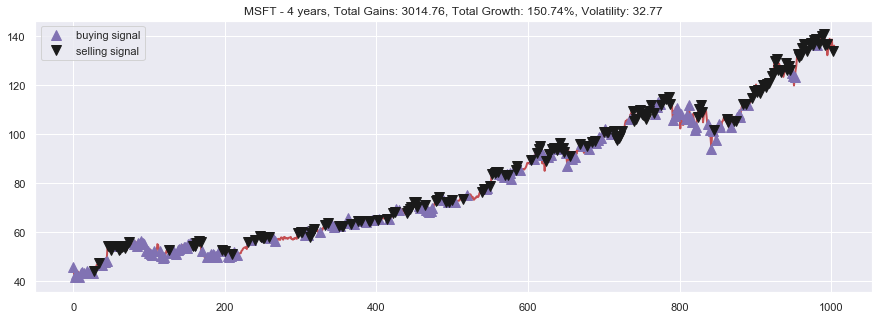

1


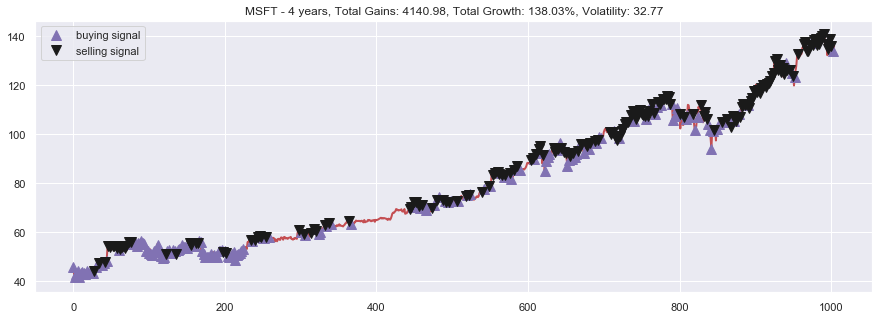

1


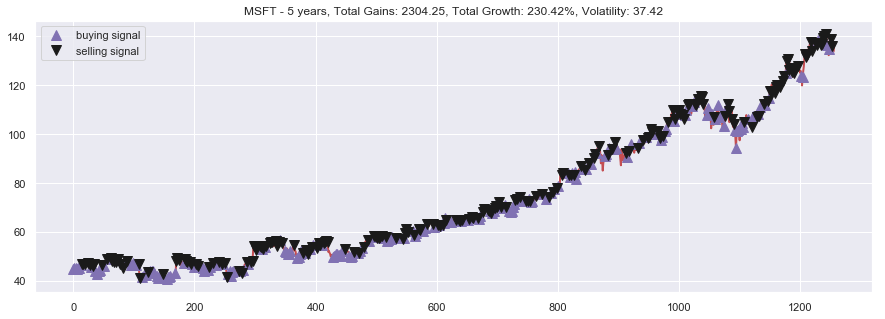

1


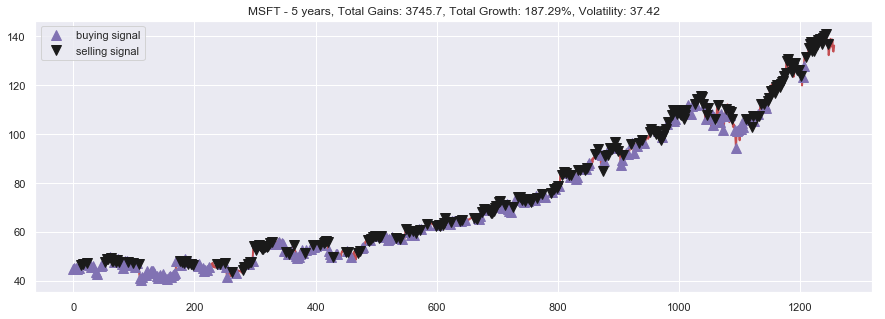

1


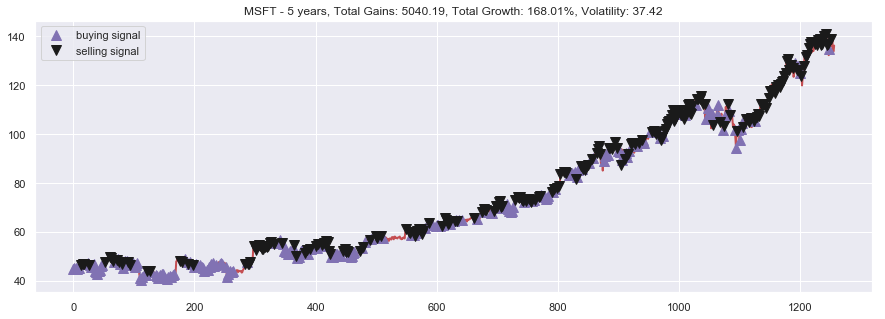

1


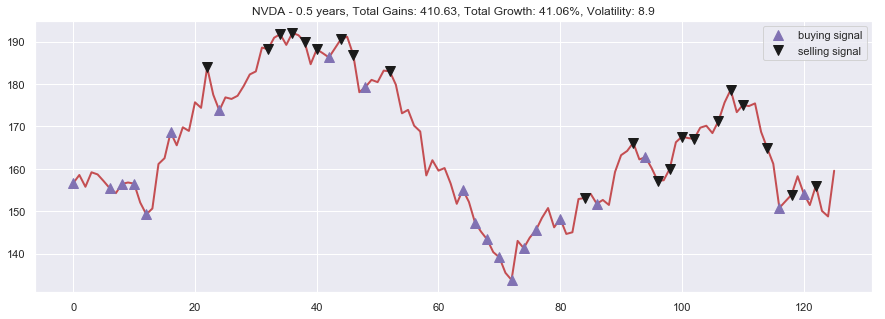

1


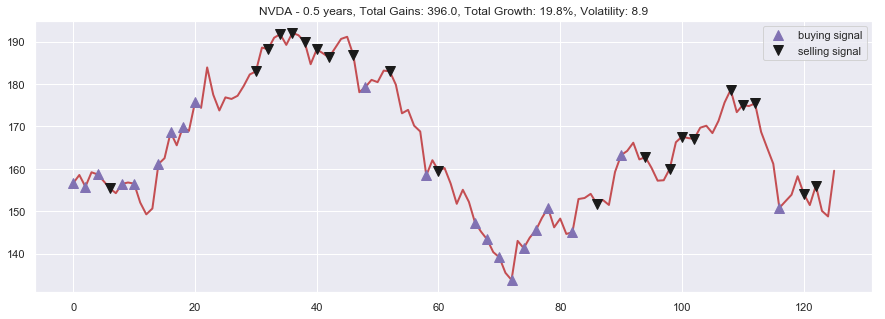

1


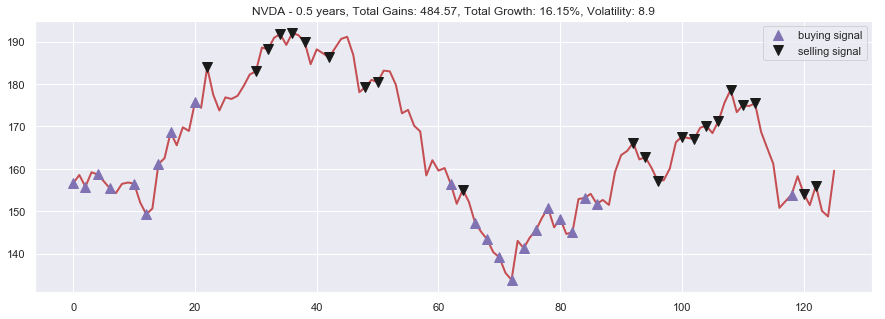

1


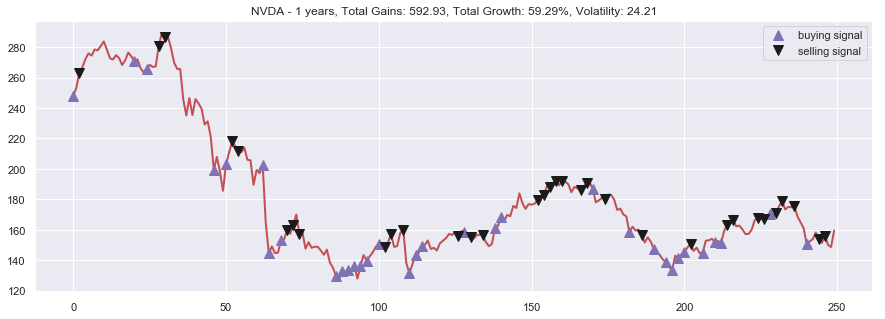

1


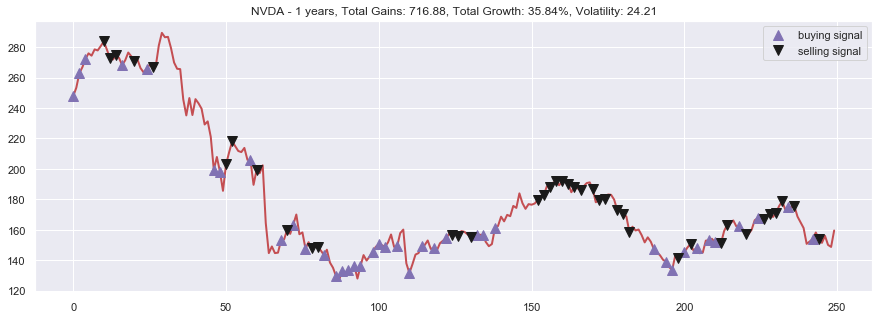

1


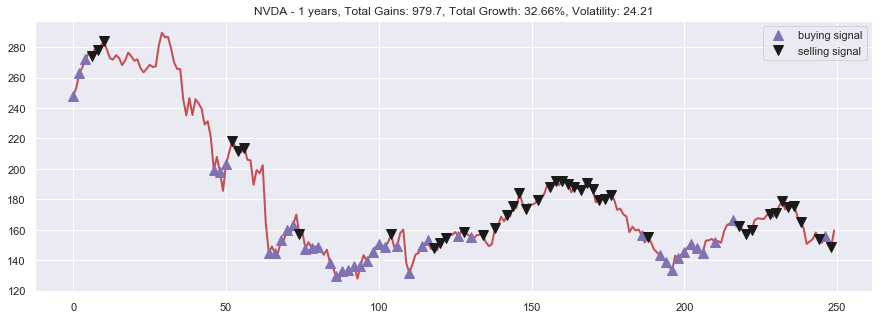

1


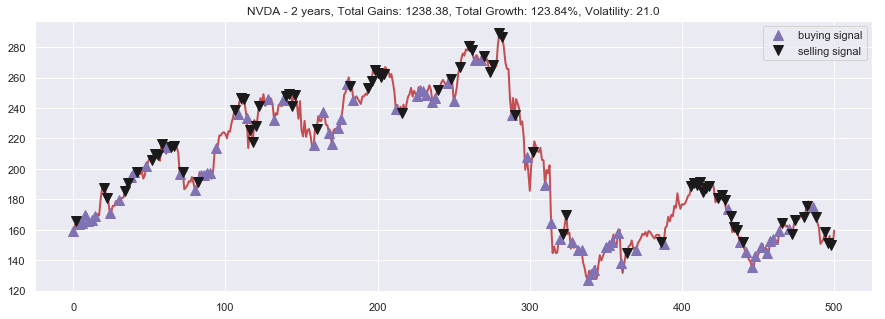

1


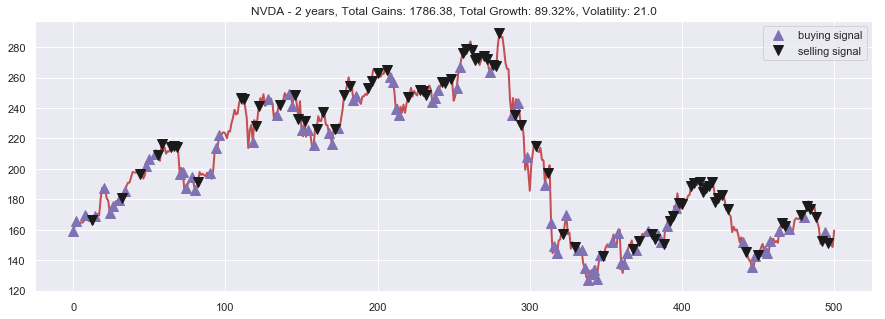

1


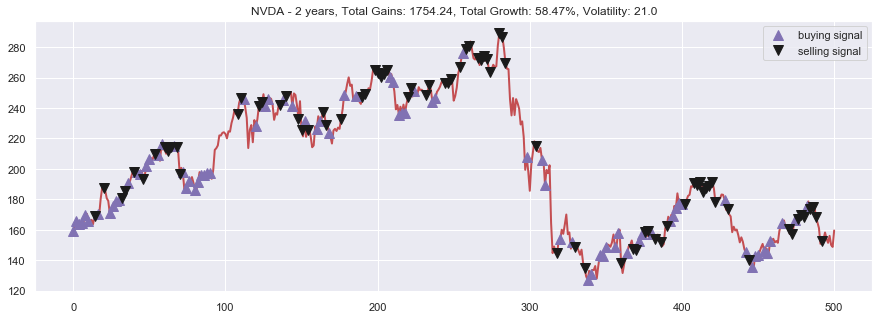

1


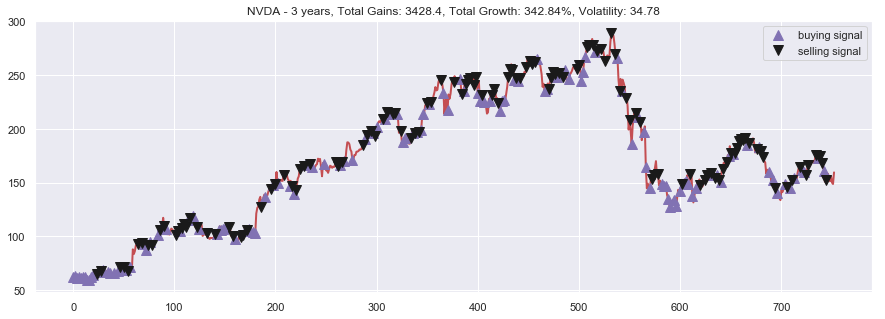

1


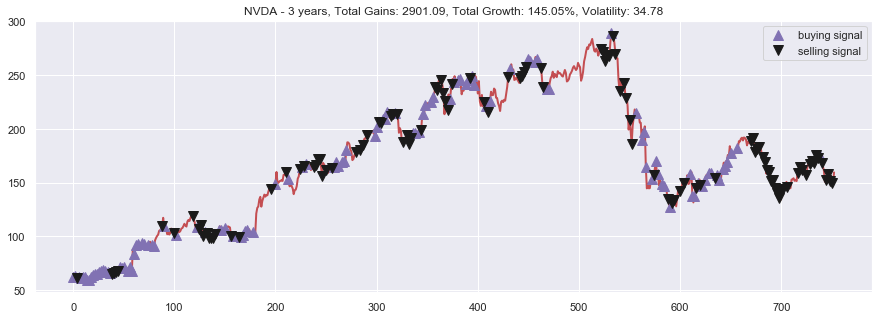

1


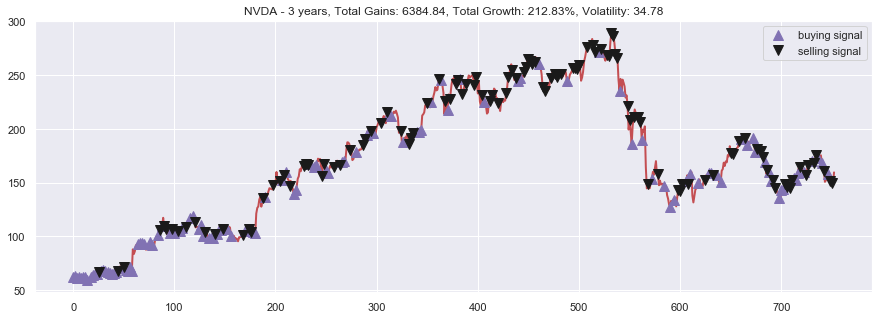

1


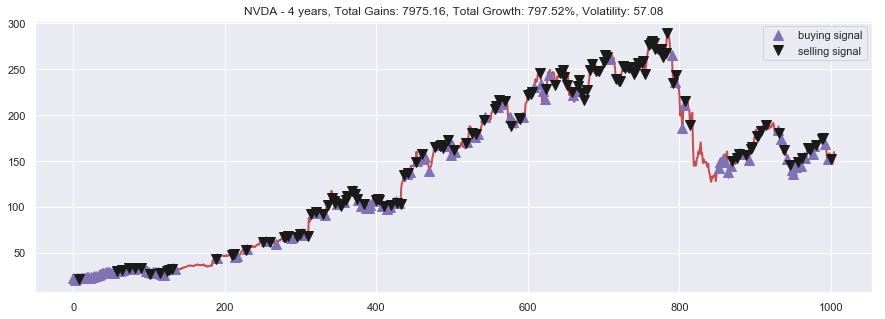

1


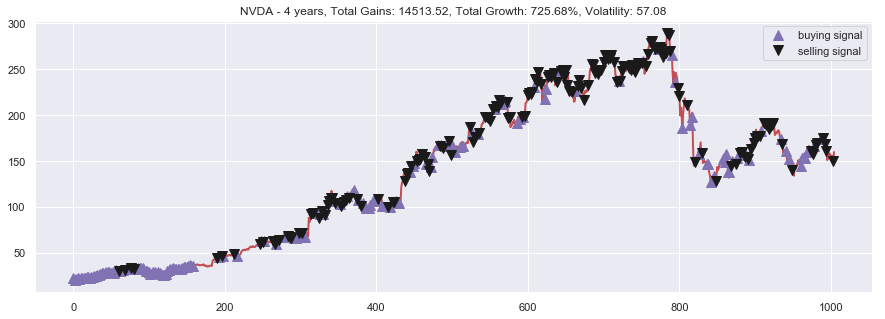

1


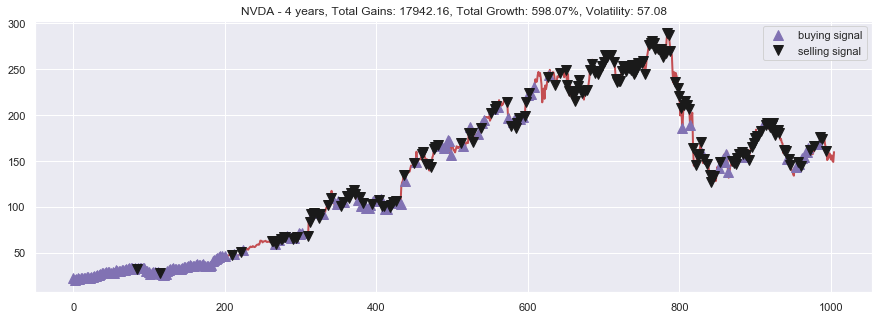

1


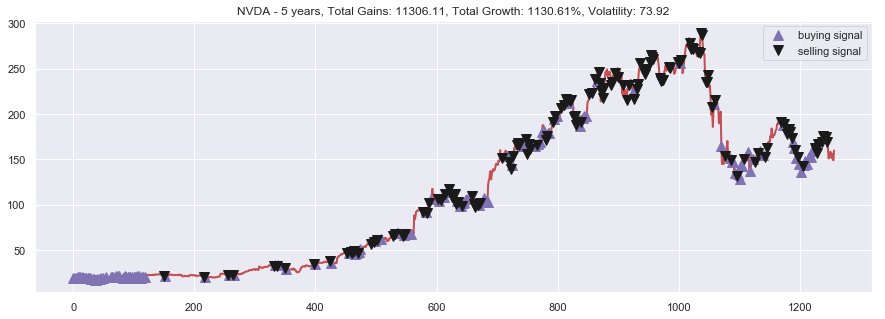

1


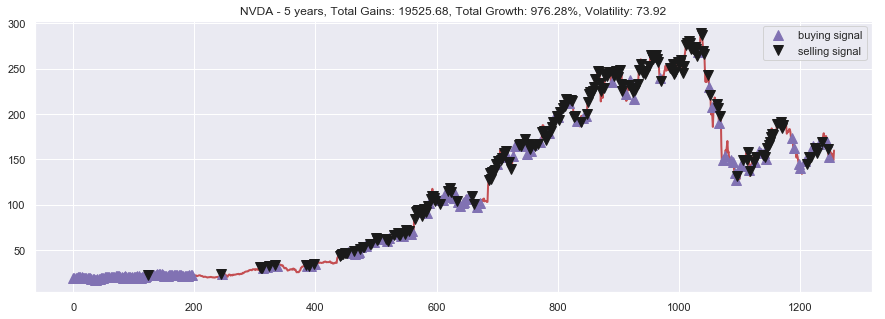

1


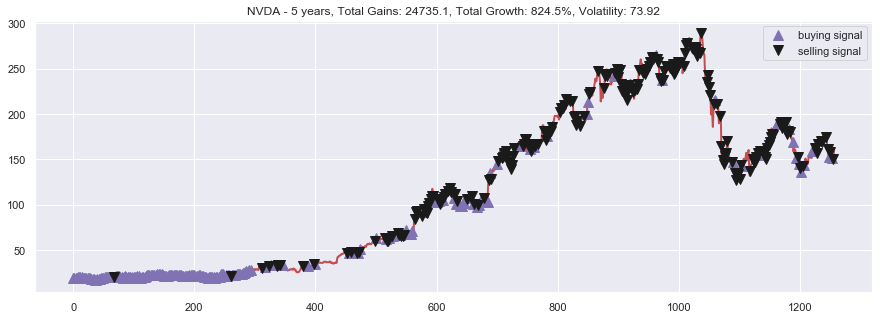

1


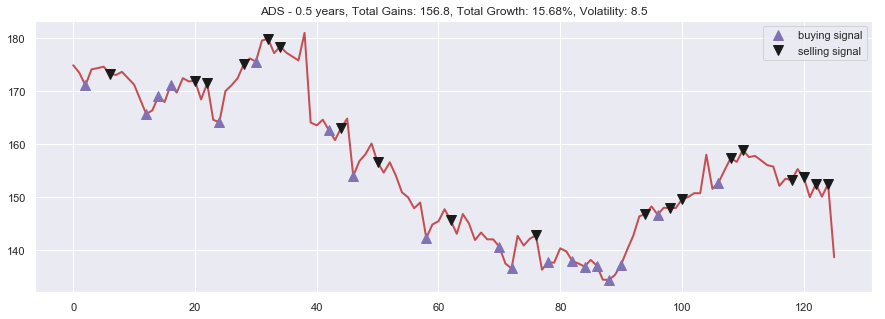

1


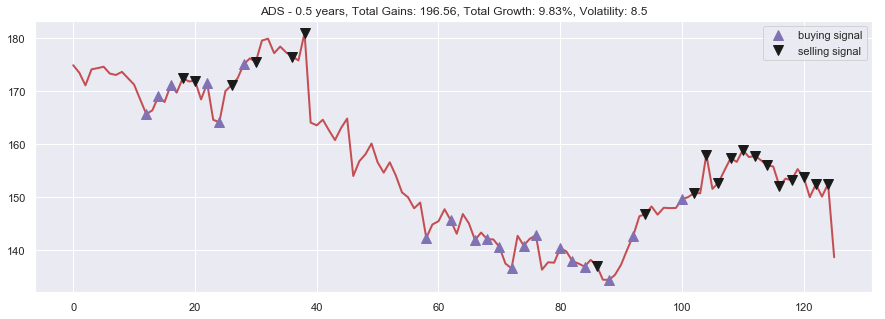

1


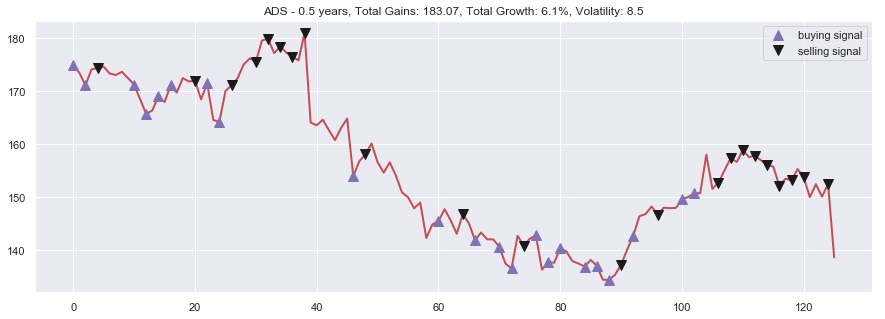

1


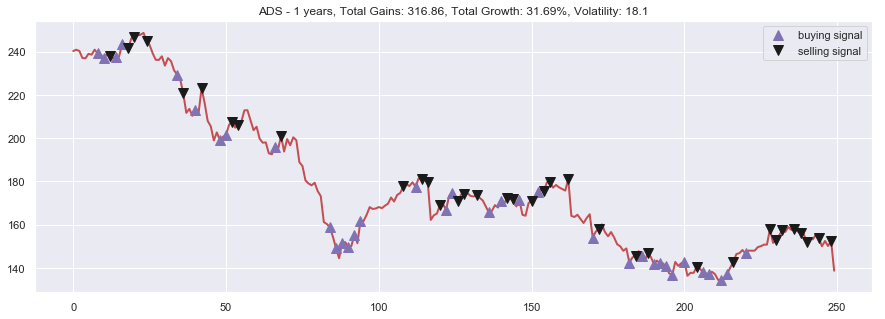

1


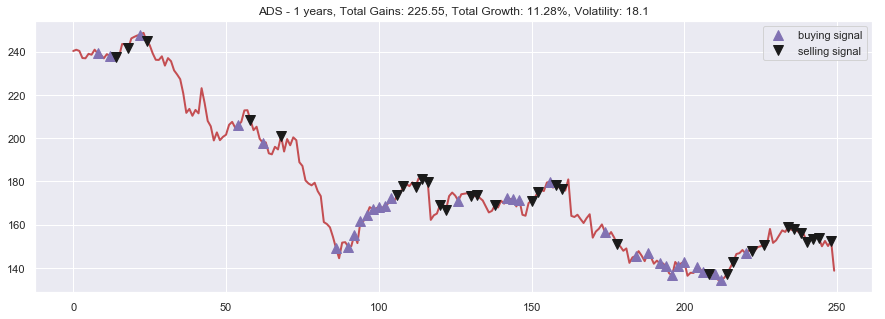

1


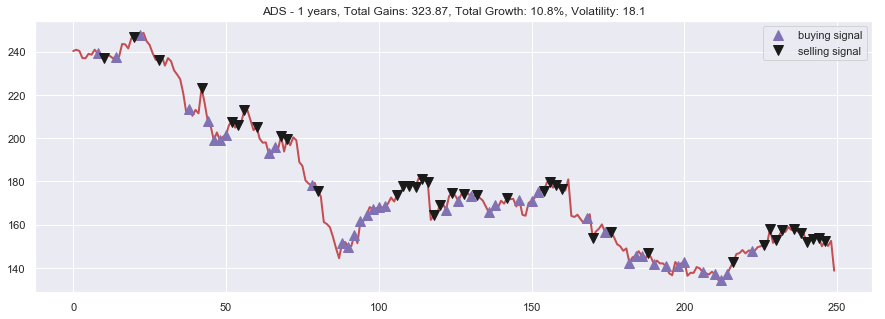

1


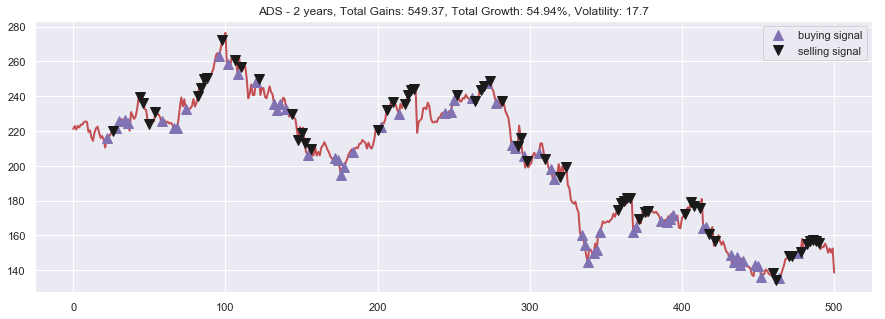

1


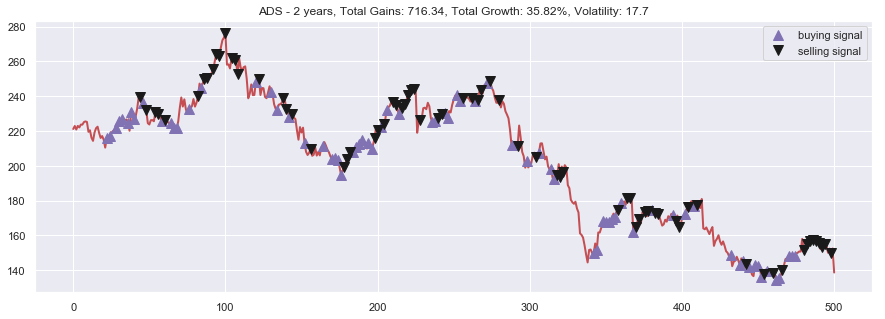

1


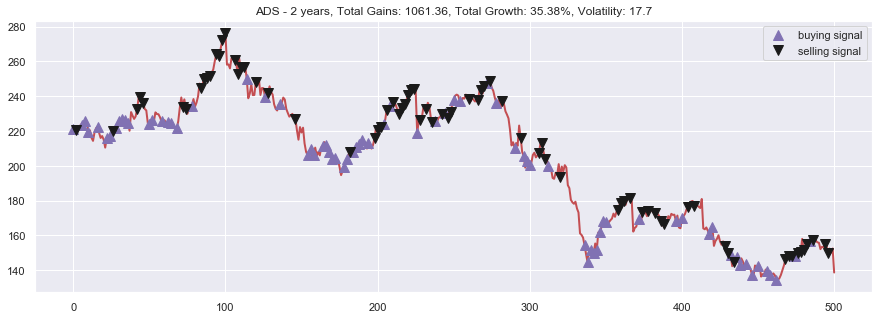

1


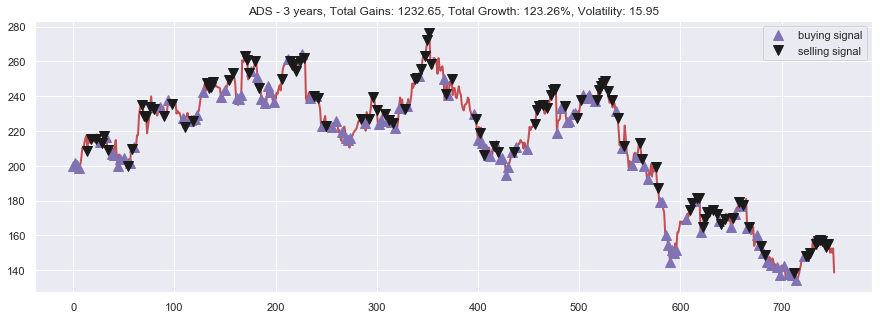

1


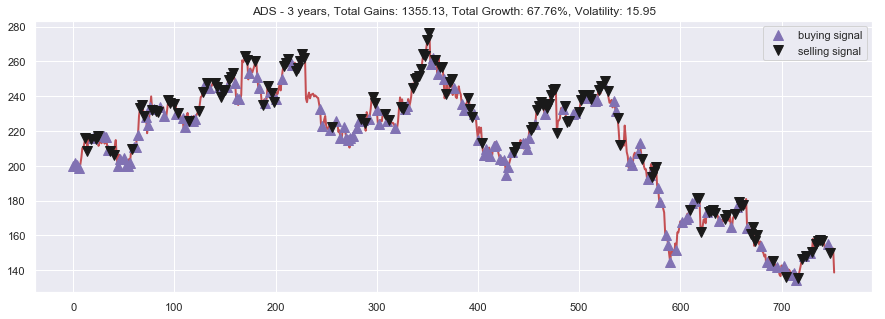

1


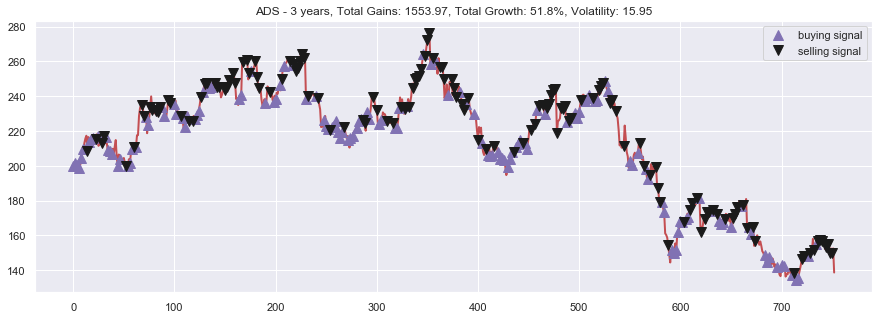

1


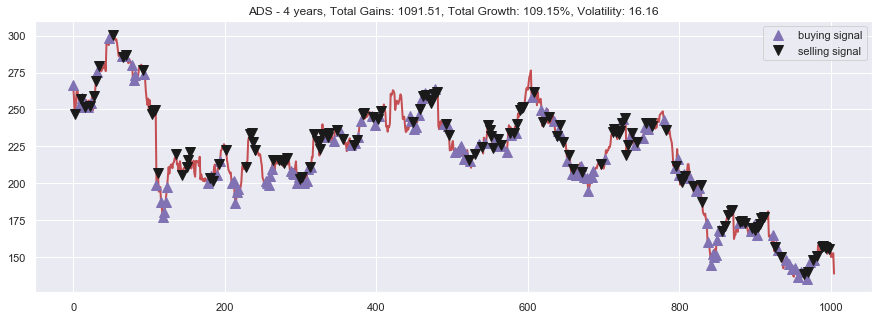

1


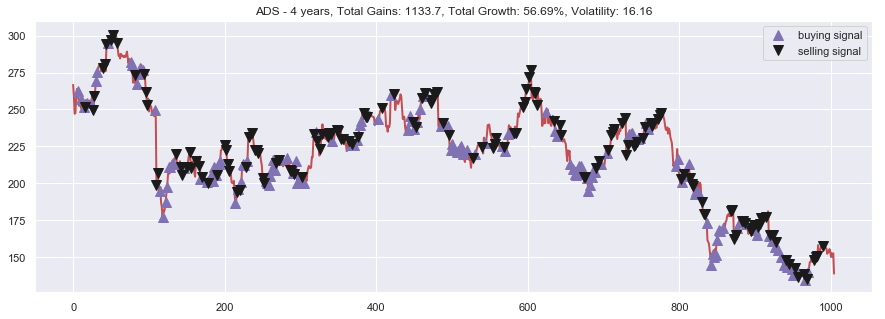

1


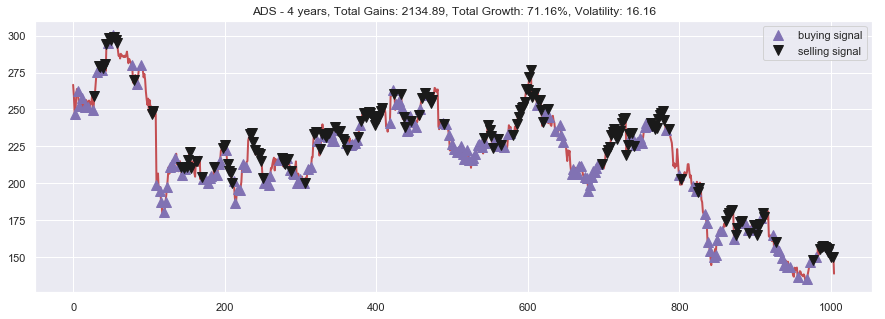

1


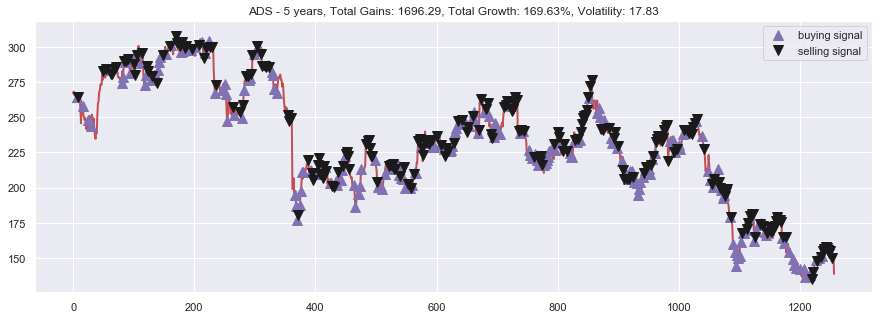

1


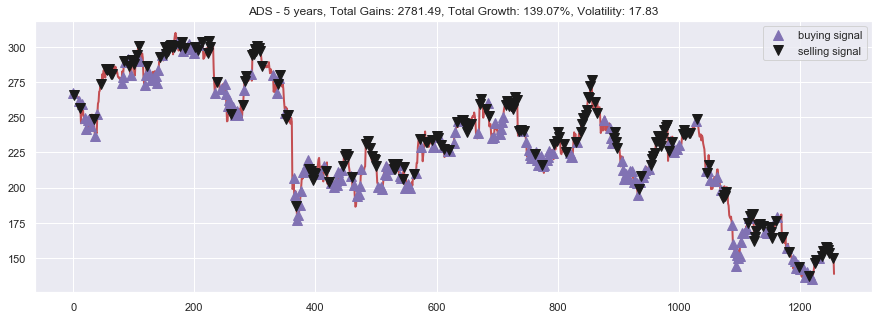

1


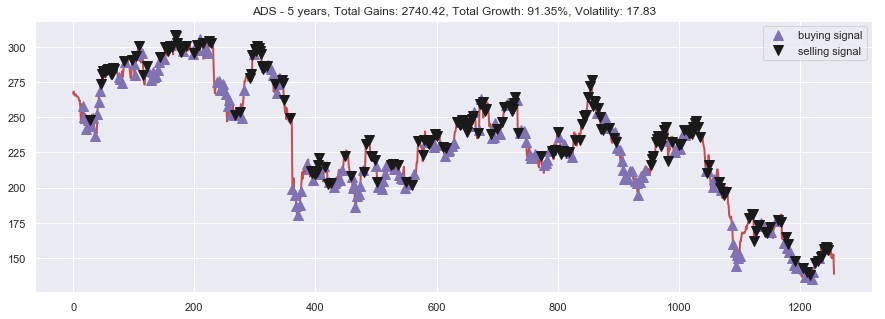

1


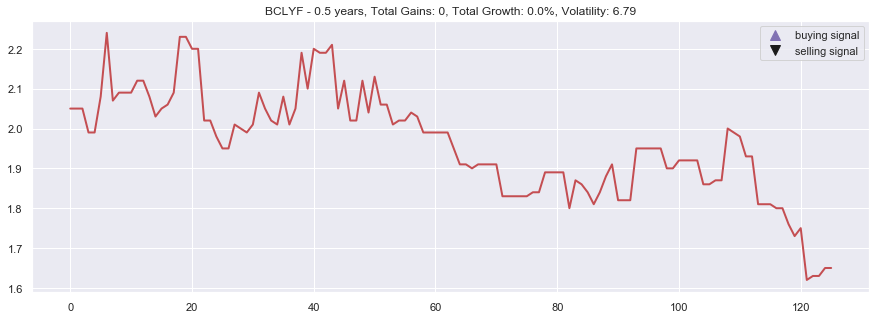

1


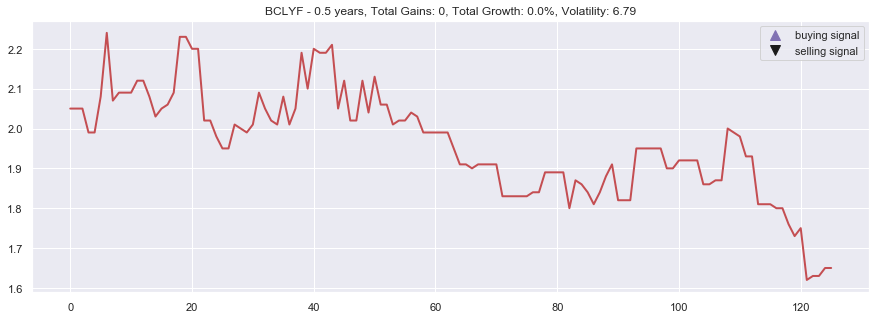

1


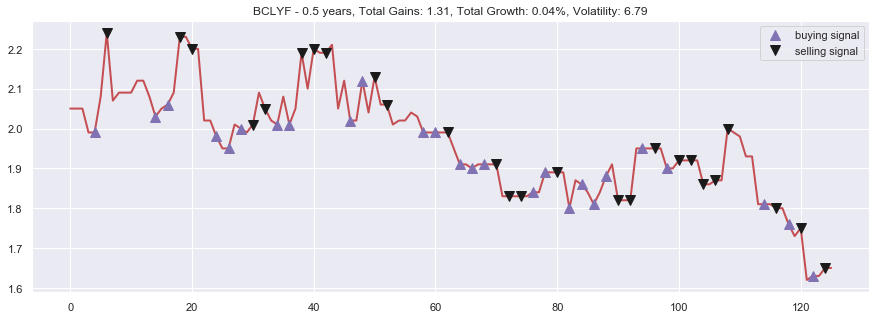

1


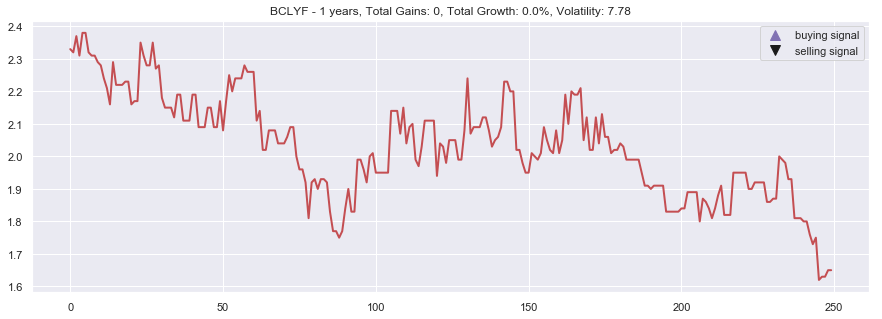

1


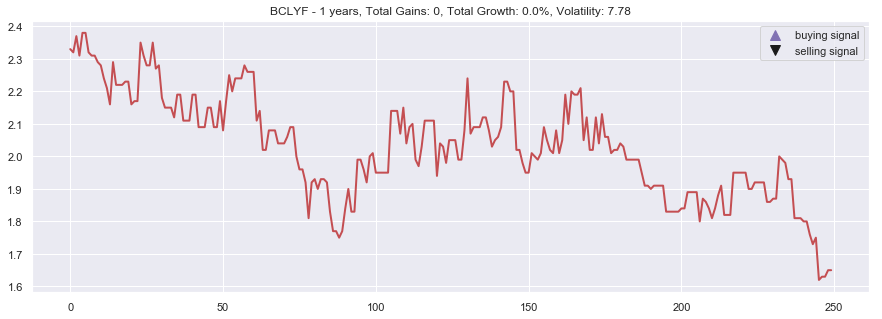

1


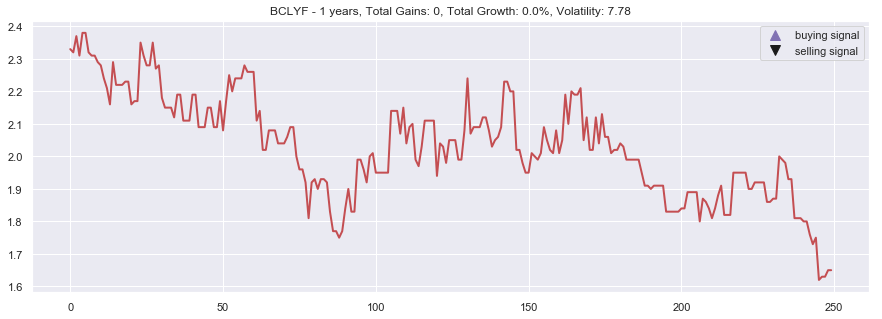

1


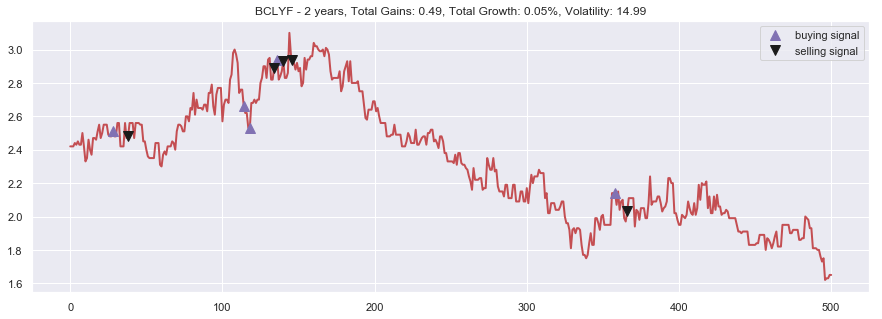

1


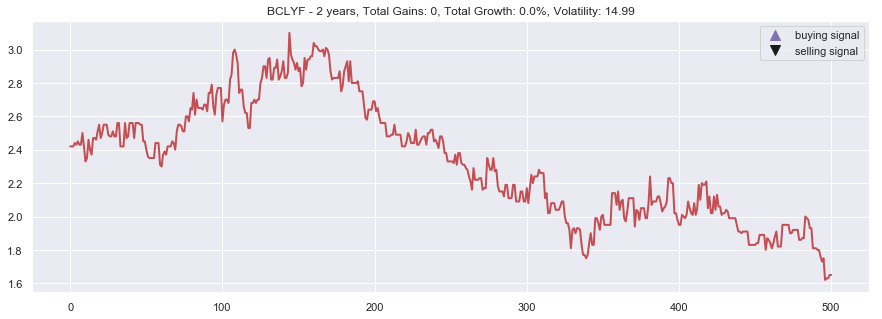

1


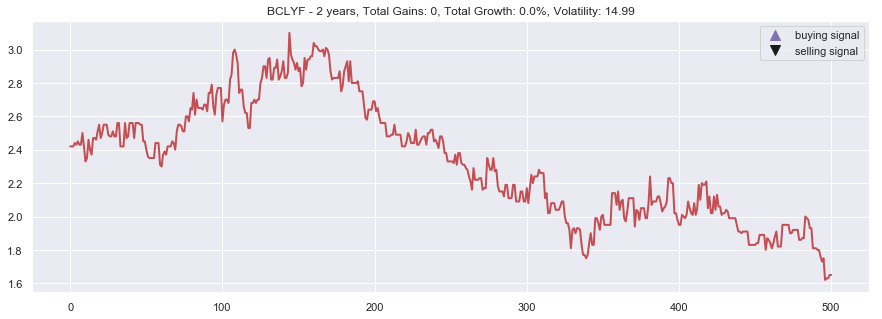

1


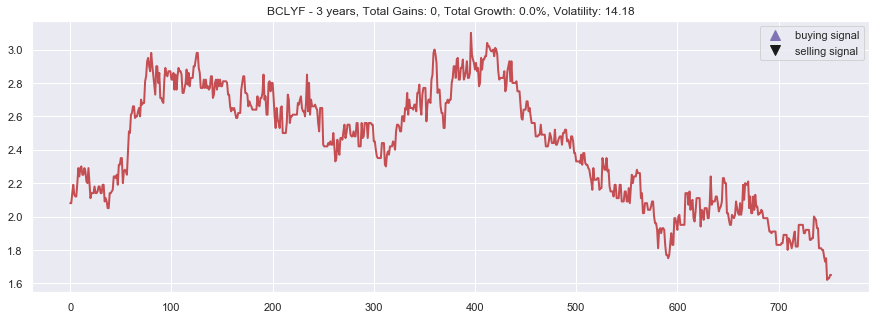

1


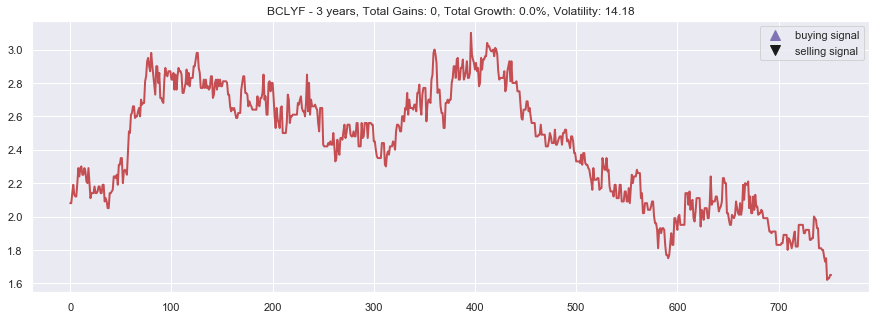

1


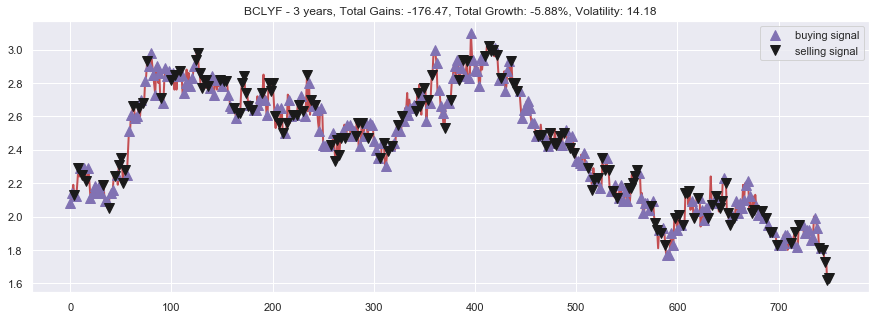

1


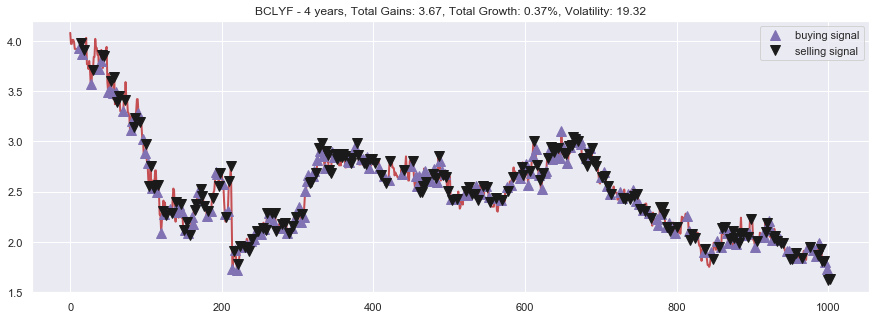

1


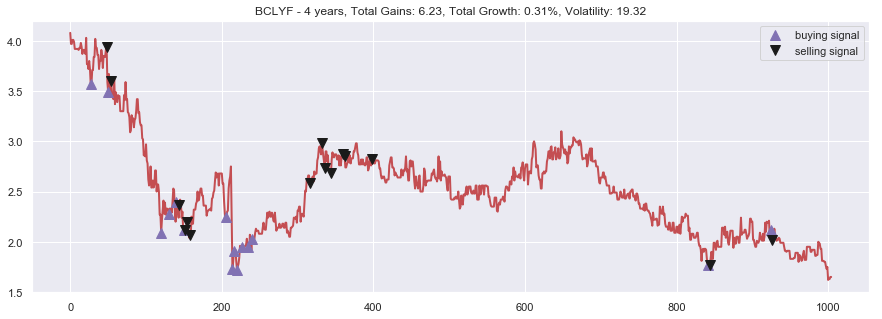

1


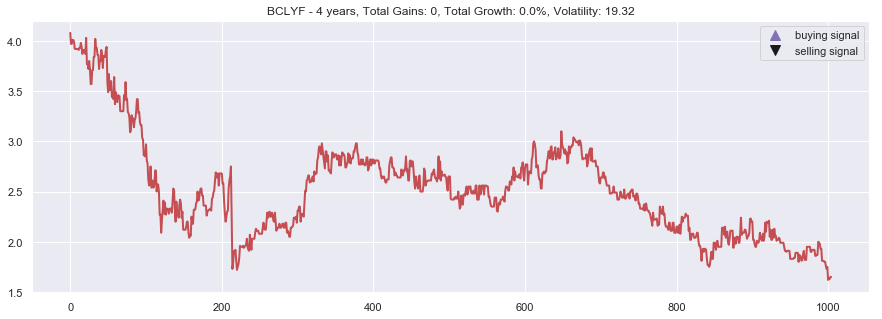

1


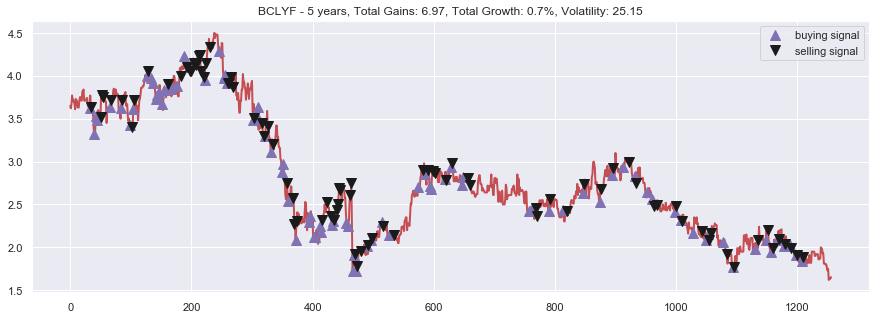

1


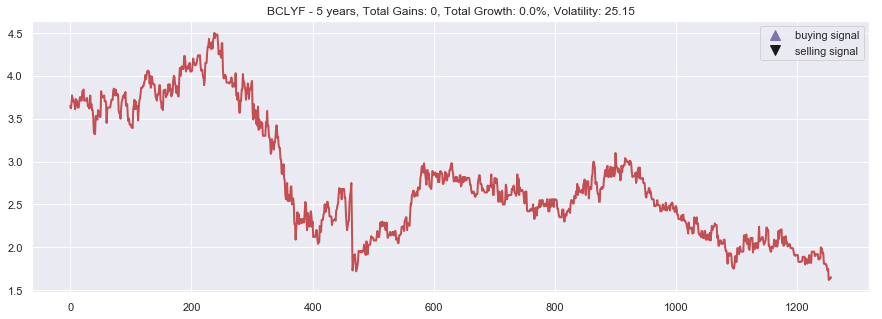

1


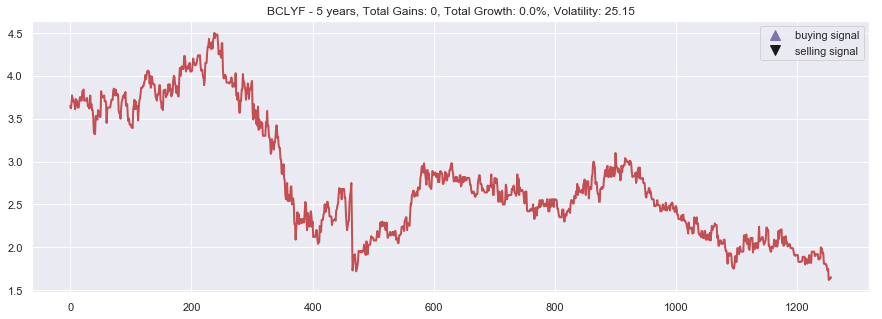

In [9]:
config = {
    "years": [0.5, 1, 2, 3, 4, 5],
    "initial_investment": [1000, 2000, 3000],
    "tickers": {
        "gainers": ["AAPL", "TSLA", "FB", "INTC", "MSFT", "NVDA"]
        ,"losers": ["ADS", "BCLYF"]
    }
}

def get_statistics(config):
    statistics = [
        [
            "Category", "Ticker", "Year", "InitialInvestment", "TotalGains",
            "InvestmentGrowth", "PeriodVolatility", "CoefficientOfVariation"
        ]
    ]
    

    for attr, value in config["tickers"].items():
        for ticker in config["tickers"][attr]:
            for year in config["years"]:
                df = get_df(ticker, year)
#                 df = pd.read_csv('AAPL (1).csv')
                close = df.Close.values.tolist()
                
                period_volatility = df.Close.std()
                coefficient_of_variation = (period_volatility / df.Close.mean()) * 100
                
                for amount in config["initial_investment"]:
                    print("1")
                    skip = 2
                    initial_money = amount
                    window_size = 30
                    model = Model(input_size = window_size, layer_size = 500, output_size = 3)
                
                    agent = Agent(model = model, 
                                  window_size = window_size,
                                  trend = close,
                                  skip = skip,
                                  initial_money = initial_money,
                                  close = close   
                                 )
                    agent.fit(iterations = 500, checkpoint = 10)

                    states_buy, states_sell, total_gains, invest = agent.buy()

                    fig = plt.figure(figsize = (15,5))
                    plt.plot(close, color='r', lw=2.)
                    plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
                    plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
                    plt.title("{} - {} years, Total Gains: {}, Total Growth: {}%, Volatility: {}".format(
                        ticker, year, round(total_gains, 2), round(invest, 2), round(coefficient_of_variation, 2)
                    ))
                    plt.legend()
                    plt.show()
                
                    statistics.append([
                        attr, ticker, year, initial_money, total_gains, invest,
                        period_volatility, coefficient_of_variation
                    ])
    write_statistics(statistics, "stat_test3")

get_statistics(config)
